<a href="https://colab.research.google.com/github/afiliot/Language-modeling/blob/master/experiments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1><center>  Project - NLP - Spring 2019 </center></h1>
 
 
 
 <h1><center>  Language Modeling: experiments </center></h1>
 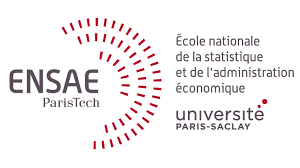
 <h3>  <p style="text-align:left;">Authors: <span style="float:right;"> Professors:<br>
     <br> Edouard Grave <br> Armand Joulin
 </span></p>
 
 Dorian Baudry <br> Alexandre Filiot

### To see the notebook on nbviewer:
### https://nbviewer.jupyter.org/github/afiliot/Language-modeling/blob/master/experiments.ipynb

# Outline
 

## <a href="#Setup" style="color:#00925B">1.&nbsp;&nbsp;Setup</a>

## <a href="#Loading data" style="color:#00925B">2.&nbsp;&nbsp;Loading data</a>

## <a href="#N-gram" style="color:#00925B">3.&nbsp;&nbsp;N-gram</a>
> ### <a href="#Testing some methods" style="color:#00925B">3.1&nbsp;&nbsp;Testing some methods</a>
>> #### <a href="#Classical n-grams" style="color:#00925B">3.1.1&nbsp;&nbsp;Classical n-grams</a>
>> #### <a href="#Add-k" style="color:#00925B">3.1.2&nbsp;&nbsp;Add-k smoothing</a>
>> #### <a href="#Good-Turing" style="color:#00925B">3.1.3&nbsp;&nbsp;Good-Turing estimation</a>
>> #### <a href="#Backoff" style="color:#00925B">3.1.4&nbsp;&nbsp;Stupid backoff</a>
>> #### <a href="#Kneser-Ney" style="color:#00925B">3.1.5&nbsp;&nbsp;Kneser-Ney smoothing</a>
> ### <a href="#Tuning and comparison" style="color:#00925B">3.2&nbsp;&nbsp;Tuning and comparison</a>
>> #### <a href="#Validation set" style="color:#00925B">3.2.1&nbsp;&nbsp;Validation set</a>
>> #### <a href="#Test set" style="color:#00925B">3.2.2&nbsp;&nbsp;Test set</a>

## <a href="#Deeper LM models" style="color:#00925B">4.&nbsp;&nbsp;Deeper LM models</a>
> ### <a href="#Testing some architectures" style="color:#00925B">4.1&nbsp;&nbsp;Testing some architectures</a>
> ### <a href="#Tuning" style="color:#00925B">4.2&nbsp;&nbsp;Tuning</a>
>> #### <a href="#LSTM" style="color:#00925B">4.2.1&nbsp;&nbsp;LSTM</a>
>> #### <a href="#BiLSTM" style="color:#00925B">4.2.2&nbsp;&nbsp;BiLSTM</a>
>> #### <a href="#GRU" style="color:#00925B">4.2.3&nbsp;&nbsp;GRU</a>
>> #### <a href="#Feed forward" style="color:#00925B">4.2.4&nbsp;&nbsp;Feed forward network</a>
>> #### <a href="#RNN" style="color:#00925B">4.2.5&nbsp;&nbsp;RNN</a>
>> #### <a href="#Bilstmconv2D" style="color:#00925B">4.2.6&nbsp;&nbsp;2D Convolutional BiLSTM</a>
> ### <a href="#Impact of parameters" style="color:#00925B">4.3&nbsp;&nbsp;Influence of parameters</a>
> ### <a href="#Overview" style="color:#00925B">4.4&nbsp;&nbsp;Overview</a>
> ### <a href="#textgen" style="color:#00925B">4.5&nbsp;&nbsp;Text generation</a>
>> #### <a href="#Tatoeba" style="color:#00925B">4.5.1&nbsp;&nbsp;Tatoeba data set</a>
>> #### <a href="#Wiki" style="color:#00925B">4.5.2&nbsp;&nbsp;Wiki data set</a>

<a id='Setup'></a>

# Setup

The following cell has to be executed if you intend to run the experiments on Google Colab **or** if you have personal GPUs. We did not have any GPUs on our personal laptops, which is why `using_gpus` is put to False. Put True otherwise. 


**If you are using colab (which I guess no), you may follow the next guidelines to avoid errors:**
- create a folder named NLP in your google drive (main menu) and open it;
- upload the notebook 'experiments.ipynb' from GitHub or directly click on 'Open in colab' (top left);
- run the cell below

If you are not using colab, just cloning the repo is needed.

In [1]:
# In case you are using Collab
%%capture
import sys
using_gpus = False
using_collab = 'google.colab' in sys.modules

# Don't show output for this cell
if using_collab:
  # mount drive
  from google.colab import drive
  drive.mount('/content/drive')
  %cd /content/drive/My Drive/NLP/
  # Unzipping the master branch from GitHub
  !wget https://github.com/afiliot/Language-modeling/archive/master.zip
  !unzip master.zip
  # Changing directory
  %cd ./Language-modeling-master/
  # Switch to GPU
  import os  
  import tensorflow as tf
  os.environ['THEANO_FLAGS'] = "device=gpu1"    
  sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))

if using_gpus:
    import os  
    import tensorflow as tf
    os.environ['THEANO_FLAGS'] = "device=gpu1"    
    sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))

UsageError: Line magic function `%%capture` not found.


Let's import the functions we need.

In [1]:
# Libraires
import sys
import os
import itertools
import numpy as np
import pandas as pd
from tqdm import tqdm
from time import time
import pickle as pkl
import warnings
import keras
import random

# Own .py files and functions
import utils
from ngram import Ngram, generate_sentence, print_pp
from recurrentNets import RecDeepNetworks, LrReducer

# Graphics
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib as mpl
mpl.style.use('ggplot')

Using TensorFlow backend.


<a id='Loading data'></a>

# Loading data

Now, we import the data (train, test and validation sets) and clean it (see `utils.clean_text` for details about cleaning). 

In [2]:
dataset = 'tatoeba'
train, test, valid = utils.read_split(dataset)
full = pd.concat((train, test, valid), axis=0)
print('\nCleaning data...')
train_new, test_new, valid_new = utils.clean_text(train), utils.clean_text(test), utils.clean_text(valid)
full_new = pd.concat((train_new, test_new, valid_new), axis=0)
print('Done.')
print('\nA few statistics:\n')
words_freq = utils.words_count(full_new)
sorted_freq = utils.sort_dict(words_freq)
print('\nMost frequent words: \n{}'.format(pd.DataFrame(sorted_freq).iloc[:10]))
print('\nA few sentences: \n{}'.format(train_new.iloc[:5, 0]))

Loading tatoeba data set...
Number of training sentences:        50000
Number of validation sentences:       5000
Number of testing sentences:          5000
Done.

Cleaning data...
Done.

A few statistics:

Total number of words: 609042
Number of unique words: 2996
Percentage of OOV: 1.181%

Most frequent words: 
      0      1
0  </s>  60000
1   <s>  60000
2   tom  21162
3     i  19784
4    to  19720
5  that  15175
6   the  12040
7   you  11952
8   not  10765
9  mary   8885

A few sentences: 
0                    <s> tomorrow is the election </s>
1               <s> you can not help but like him </s>
2               <s> what purpose would that serve </s>
3                    <s> someone will do that job </s>
4    <s> he worked hard to make his ideas <unk> at ...
Name: text, dtype: object


<a id='N-gram'></a>

# N-gram

In this part, we only make use of the `ngram.py` file as the `Ngram` class. Variations are handled directly as inputs (see `version` parameter). 

<a id='Testing some methods'></a>

## Testing some methods

<a id='Classical n-grams'></a>

### Classical n-grams

First, classic $n$-gram. Note that here we used an approximation to compute perplexity on test set. Indeed, in order to avoid $PP=+\infty$ when testing contexts have not been encountered in training contexts, we used the Laplace approximation:

$$\mathbb{P}(w_t | w_{t-k+1}^{t-1}) =\frac{c(w_{t-k+1}^{t}) + 1}{c(w_{t-k+1}^{t-1})+V}$$


When a test context is totally unknow, then we set $\mathbb{P}(w_t | w_{t-k+1}^{t-1})$ to $\frac{1}{V}$. If we don't do that, then there still exists test contexts that are unknown from training (for bigram, it can't happen as rare words are tagged with <'UNK'>). This approximation makes no sense has classical $n$-grams are known to generalize very badly, hence are not satisfying for language modeling with moderate corpus size (our case). But it is the only way to make perplexities appear on a graph.

Let's first execute some basic n-grams, from unigram to 6-gram.

In [4]:
ng1 = Ngram(n=1, version='classical', verbose=False)
ng1.compute_probabilities(train_new)
print_pp(ng1, train_new, valid_new, test_new)
print()
ng2 = Ngram(n=2, version='classical', verbose=True)
ng2.compute_probabilities(train_new)
print_pp(ng2, train_new, valid_new, test_new)
print()
ng3 = Ngram(n=3, version='classical', verbose=True)
ng3.compute_probabilities(train_new)
ng1.compute_perplexity(test_new)
print_pp(ng3, train_new, valid_new, test_new)
print()
ng4 = Ngram(n=4, version='classical', verbose=True)
ng4.compute_probabilities(train_new)
print_pp(ng4, train_new, valid_new, test_new)
print()
ng5 = Ngram(n=5, version='classical', verbose=True)
ng5.compute_probabilities(train_new)
print_pp(ng5, train_new, valid_new, test_new)
print()
ng6 = Ngram(n=6, version='classical', verbose=True)
ng6.compute_probabilities(train_new)
print_pp(ng6, train_new, valid_new, test_new)


Perplexity on train set: 13461719.21
Perplexity on val set: 14325120.22
Perplexity on test set: 11717065.92

Running classical 2-gram model...

0 null ngram probabilities found in perplexity
2 null sentence probabilities found in perplexity.
Done. Time elapsed: 3.7 sec.
Perplexity on train set: 1572.25
0 null ngram probabilities found in perplexity
0 null sentence probabilities found in perplexity.
Done. Time elapsed: 3.9 sec.
Perplexity on val set: 1646.87
0 null ngram probabilities found in perplexity
2 null sentence probabilities found in perplexity.
Done. Time elapsed: 4.2 sec.
Perplexity on test set: 1589.65

Running classical 3-gram model...

0 null ngram probabilities found in perplexity
0 null sentence probabilities found in perplexity.
Done. Time elapsed: 4.5 sec.
Perplexity on train set: 20.89
1 null ngram probabilities found in perplexity
0 null sentence probabilities found in perplexity.
Done. Time elapsed: 4.8 sec.
Perplexity on val set: 111.59
0 null ngram probabilities 

Even for bigram models, some sentences have 0 probability because of their length... despite doing the sum-log-exp trick, the product of small probabilities yields 0 on overall. Here are the 2 sentences of the **test set**: 

` • <s> a certain man was going down from <unk> to <unk> and he fell among <unk> who both <unk> him and beat him and <unk> leaving him half dead by chance a certain <unk> was going down that way when he saw him he passed by on the other side in the same way a <unk> also when he came to the place and saw him passed by on the other side but a certain <unk> as he <unk> came where he was when he saw him he was moved with <unk> came to him and bound up his <unk> <unk> on oil and wine he set him on his own animal and brought him to an <unk> and took care of him </s>`


`• <s> here you have translated from the sentence in <unk> the language you have translated from <unk> and you created a link to that one i think this is the sentence in <unk> the language you want to translate from <unk> that you wanted to translate to do this you must first <unk> on the sentence in <unk> the language you want to translate from <unk> before <unk> on the translation button the sentence that you are <unk> must always stand on top of the <unk> in the largest <unk> and it is the only one <unk> at the time you re <unk> your translation and that is on purpose to avoid influence on your translation as in tatoeba sentences are <unk> by <unk> not as <unk> since a sentence may have several different <unk> in the same language </s>`

Starting from 4-grams, some test grams can not be found in train (leading to infinite perplexity). Here are the 2 4-grams of test set: `know where john i`, `where john is planning`.

4 5-grams of test set: `t know where john is`, `know where john is planning`, `where john is planning to`, `is planning to go </s>`.


Now let's visualize the perplexities using the Laplace approximation.

**First on `tatoeba` data set.**

100%|██████████| 10/10 [00:40<00:00,  3.25s/it]


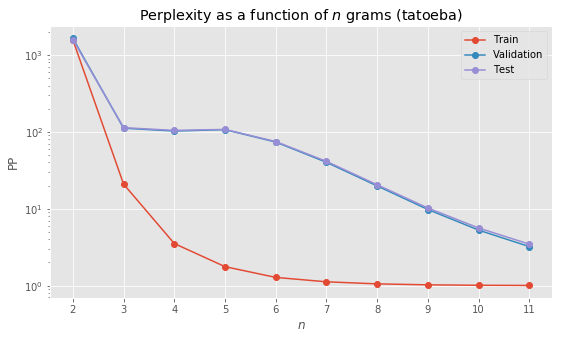

In [14]:
Nmax = 11
Nmin = 2
Ns = range(Nmin, Nmax+1)
PPs = np.zeros((Nmax-Nmin+1, 3))
for j, n in tqdm(enumerate(Ns), total=len(Ns)):
    ng = Ngram(n=n, version='classical', verbose=False)
    ng.compute_probabilities(train_new)
    perp_train = ng.compute_perplexity(train_new)
    perp_val = ng.compute_perplexity(valid_new)
    perp_test = ng.compute_perplexity(test_new)
    PPs[j] = [perp_train, perp_val, perp_test]
plt.figure(figsize=(9, 5))
plt.semilogy(Ns, PPs[:, 0], marker='o', label='Train')
plt.semilogy(Ns, PPs[:, 1], marker='o', label='Validation')
plt.semilogy(Ns, PPs[:, 2], marker='o', label='Test')
plt.xticks(Ns, Ns)
plt.xlabel(r'$n$'); plt.ylabel('PP')
plt.title(r'Perplexity as a function of $n$ grams (tatoeba)')
plt.legend()
plt.show()

**Then on `wiki` data set.**

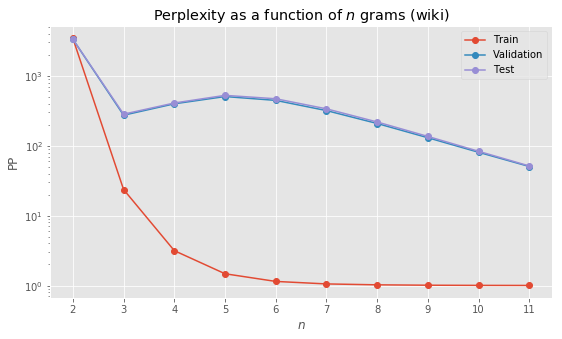

In [16]:
dataset = 'wiki'
train, test, valid = utils.read_split(dataset)
train_new, test_new, valid_new = utils.clean_text(train), utils.clean_text(test), utils.clean_text(valid)
Nmax = 11
Nmin = 2
Ns = range(Nmin, Nmax+1)
PPs = np.zeros((Nmax-Nmin+1, 3))
for j, n in tqdm(enumerate(Ns), total=len(Ns)):
    ng = Ngram(n=n, version='classical', verbose=False)
    ng.compute_probabilities(train_new)
    perp_train = ng.compute_perplexity(train_new)
    perp_val = ng.compute_perplexity(valid_new)
    perp_test = ng.compute_perplexity(test_new)
    PPs[j] = [perp_train, perp_val, perp_test]

plt.figure(figsize=(9, 5))
plt.semilogy(Ns, PPs[:, 0], marker='o', label='Train')
plt.semilogy(Ns, PPs[:, 1], marker='o', label='Validation')
plt.semilogy(Ns, PPs[:, 2], marker='o', label='Test')
plt.xticks(Ns, Ns)
plt.xlabel(r'$n$'); plt.ylabel('PP')
plt.title(r'Perplexity as a function of $n$ grams (wiki)')
plt.legend()
plt.show()

And generate some text on `tatoeba`! 

First with sentence from train set.

In [11]:
n_next = 3
for _ in range(20):
    i = random.choice(range(train_new.shape[0]))
    split = 4
    truth = train_new.text.iloc[i]
    seed_text = utils.split_and_join(truth, split)
    print('Input:       %s' % seed_text)
    sentence = generate_sentence(seed_text, 3, [ng5, ng4, ng3, ng2, ng1])
    print('Predicted:   %s' % sentence)
    print('Truth:       %s' %  truth)
    print('___________________________________________________\n')

Input:       <s> mary eventually changed
Predicted:   <s> mary eventually changed her mind </s>
Truth:       <s> mary eventually changed her mind </s>
___________________________________________________

Input:       <s> i thought tom
Predicted:   <s> i thought tom and mary were
Truth:       <s> i thought tom and mary weren t afraid </s>
___________________________________________________

Input:       <s> tom could ve
Predicted:   <s> tom could ve been warned </s>
Truth:       <s> tom could ve kicked himself </s>
___________________________________________________

Input:       <s> have you already
Predicted:   <s> have you already paid tom </s>
Truth:       <s> have you already paid tom </s>
___________________________________________________

Input:       <s> this offer ends
Predicted:   <s> this offer ends soon </s>
Truth:       <s> this offer ends soon </s>
___________________________________________________

Input:       <s> drink water only
Predicted:   <s> drink water only when

In [12]:
import random
n_next = 3
for _ in range(20):
    i = random.choice(range(test_new.shape[0]))
    split = 4
    truth = test_new.text.iloc[i]
    seed_text = utils.split_and_join(truth, split)
    print('Input:       %s' % seed_text)
    sentence = generate_sentence(seed_text, n_next, [ng5, ng4, ng3, ng2, ng1])
    print('Predicted:   %s' % sentence)
    print('Truth:       %s' %  truth)
    print('___________________________________________________\n')

Input:       <s> did you post
Predicted:   <s> did you post office </s>
Truth:       <s> did you post that on facebook or something </s>
___________________________________________________

Input:       <s> tom mary and
Predicted:   <s> tom mary and a few other
Truth:       <s> tom mary and john are sitting around the table </s>
___________________________________________________

Input:       <s> what makes you
Predicted:   <s> what makes you think tom will
Truth:       <s> what makes you think that i ll accept </s>
___________________________________________________

Input:       <s> i ll persuade
Predicted:   <s> i ll persuade tom to do
Truth:       <s> i ll persuade him not to go </s>
___________________________________________________

Input:       <s> sami moved a
Predicted:   <s> sami moved a <unk> </s>
Truth:       <s> sami moved a lot </s>
___________________________________________________

Input:       <s> impossible things sometimes
Predicted:   <s> impossible things someti

Now longer predictions on test.

In [14]:
import random
n_next = 15
for _ in range(20):
    i = random.choice(range(test_new.shape[0]))
    split = 4
    truth = test_new.text.iloc[i]
    seed_text = utils.split_and_join(truth, split)
    print('Input:       %s' % seed_text)
    sentence = generate_sentence(seed_text, n_next, [ng5, ng4, ng3, ng2, ng1])
    print('Predicted:   %s' % sentence)
    print('Truth:       %s' %  truth)
    print('___________________________________________________\n')

Input:       <s> the guests in
Predicted:   <s> the guests in the <unk> </s>
Truth:       <s> the guests in the international hotel often <unk> and smile </s>
___________________________________________________

Input:       <s> a long time
Predicted:   <s> a long time </s>
Truth:       <s> a long time ago there was a bridge there </s>
___________________________________________________

Input:       <s> i don t
Predicted:   <s> i don t think that tom knows what mary is trying to do </s>
Truth:       <s> i don t have much money in the bank </s>
___________________________________________________

Input:       <s> tom told me
Predicted:   <s> tom told me that he thought mary was not as cooperative as she should have been </s>
Truth:       <s> tom told me that mary was in jail </s>
___________________________________________________

Input:       <s> tom and i
Predicted:   <s> tom and i are going to boston </s>
Truth:       <s> tom and i are almost finished </s>
_________________________

Finally, let's try with brand new sentences, the most interesting ! 

**On `tatoeba`.**

In [16]:
dataset = 'tatoeba'
train, test, valid = utils.read_split(dataset)
train_new, test_new, valid_new = utils.clean_text(train), utils.clean_text(test), utils.clean_text(valid)

proposals = ['he does not',
            'I am happy',
            'I need you',
            '<s> Let s take a',
            'He used to play the',
            'Come on be',
            '<s> Do you want',
            'He does not like',
            'The dogs eat the',
            'he is in a meeting with',
            'what are you planning to',
            'i want to transfer this',
            'we are now',
            'can i have',
            'how old',
            'the cat is']

n_next = 5
for seed_text in proposals:
    print('Input:       %s' % seed_text)
    sentence = generate_sentence(seed_text, n_next, [ng5, ng4, ng3, ng2, ng1])
    print('Predicted:   %s' % sentence)
    print('___________________________________________________\n')

Input:       he does not
Predicted:   he does not think that mary really had
___________________________________________________

Input:       I am happy
Predicted:   I am happy to meet you </s>
___________________________________________________

Input:       I need you
Predicted:   I need you to do that </s>
___________________________________________________

Input:       <s> Let s take a
Predicted:   <s> Let s take a look at this machine </s>
___________________________________________________

Input:       He used to play the
Predicted:   He used to play the <unk> </s>
___________________________________________________

Input:       Come on be
Predicted:   Come on be able to do that </s>
___________________________________________________

Input:       <s> Do you want
Predicted:   <s> Do you want to go to boston with
___________________________________________________

Input:       He does not like
Predicted:   He does not like to be the first one
________________________________

**On `wiki`.**

In [20]:
dataset = 'wiki'
train, test, valid = utils.read_split(dataset)
train_new, test_new, valid_new = utils.clean_text(train), utils.clean_text(test), utils.clean_text(valid)

ng1 = Ngram(n=1, version='classical', verbose=True)
ng1.compute_probabilities(train_new)
ng2 = Ngram(n=2, version='classical', verbose=True)
ng2.compute_probabilities(train_new)
ng3 = Ngram(n=3, version='classical', verbose=True)
ng3.compute_probabilities(train_new)
ng4 = Ngram(n=4, version='classical', verbose=True)
ng4.compute_probabilities(train_new)
ng5 = Ngram(n=5, version='classical', verbose=True)
ng5.compute_probabilities(train_new)
ng6 = Ngram(n=6, version='classical', verbose=True)
ng6.compute_probabilities(train_new)    

Loading wiki data set...
Number of training sentences:        60000
Number of validation sentences:       3000
Number of testing sentences:          3000
Done.
Running classical 1-gram model...
Running classical 2-gram model...
Running classical 3-gram model...
Running classical 4-gram model...
Running classical 5-gram model...
Running classical 6-gram model...


In [21]:
n_next = 5
for seed_text in proposals:
    print('Input:       %s' % seed_text)
    sentence = generate_sentence(seed_text, n_next, [ng5, ng4, ng3, ng2, ng1])
    print('Predicted:   %s' % sentence)
    print('___________________________________________________\n')

Input:       he does not
Predicted:   he does not want to make <unk> better
___________________________________________________

Input:       I am happy
Predicted:   I am happy </s>
___________________________________________________

Input:       I need you
Predicted:   I need you can help wikipedia by adding
___________________________________________________

Input:       <s> Let s take a
Predicted:   <s> Let s take a <unk> after the xxxx commonwealth
___________________________________________________

Input:       He used to play the
Predicted:   He used to play the game of <unk> to play
___________________________________________________

Input:       Come on be
Predicted:   Come on be <unk> </s>
___________________________________________________

Input:       <s> Do you want
Predicted:   <s> Do you want to <unk> mount <unk> with
___________________________________________________

Input:       He does not like
Predicted:   He does not like the development plans approved by
____

<a id='Add-k'></a>

### Add-k

Here k=1.

In [ ]:
dataset = 'tatoeba'
train, test, valid = utils.read_split(dataset)
train_new, test_new, valid_new = utils.clean_text(train), utils.clean_text(test), utils.clean_text(valid)

100%|██████████| 11/11 [00:45<00:00,  3.07s/it]


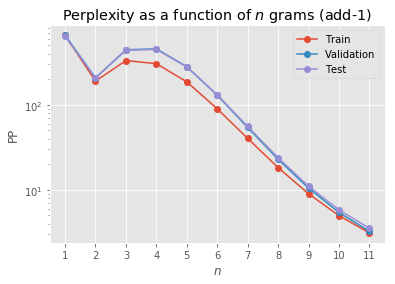

In [19]:
Nmax = 11
Nmin = 1
Ns = range(Nmin, Nmax+1)
PPs = np.zeros((Nmax-Nmin+1, 3))
for j, n in tqdm(enumerate(Ns), total=len(Ns)):
    ng = Ngram(n=n, version='add-1', verbose=False)
    ng.compute_probabilities(train_new)
    perp_train = ng.compute_perplexity(train_new)
    perp_val = ng.compute_perplexity(valid_new)
    perp_test = ng.compute_perplexity(test_new)
    PPs[j] = [perp_train, perp_val, perp_test]
plt.semilogy(Ns, PPs[:, 0], marker='o', label='Train')
plt.semilogy(Ns, PPs[:, 1], marker='o', label='Validation')
plt.semilogy(Ns, PPs[:, 2], marker='o', label='Test')
plt.xticks(Ns, Ns)
plt.xlabel(r'$n$'); plt.ylabel('PP')
plt.title(r'Perplexity as a function of $n$ grams (add-1)')
plt.legend()
plt.show()

Now let's generate some text on the same proposals as before.

In [22]:
ng1 = Ngram(n=1, version='add-1', verbose=True)
ng1.compute_probabilities(train_new)
ng2 = Ngram(n=2, version='add-1', verbose=True)
ng2.compute_probabilities(train_new)
ng3 = Ngram(n=3, version='add-1', verbose=True)
ng3.compute_probabilities(train_new)
ng4 = Ngram(n=4, version='add-1', verbose=True)
ng4.compute_probabilities(train_new)
ng5 = Ngram(n=5, version='add-1', verbose=True)
ng5.compute_probabilities(train_new)
ng6 = Ngram(n=6, version='add-1', verbose=True)
ng6.compute_probabilities(train_new)

Running add-1 1-gram model...
Running add-1 2-gram model...
Running add-1 3-gram model...
Running add-1 4-gram model...
Running add-1 5-gram model...
Running add-1 6-gram model...


In [23]:
n_next = 5
for seed_text in proposals:
    print('Input:       %s' % seed_text)
    sentence = generate_sentence(seed_text, n_next, [ng6, ng5, ng4, ng3, ng2, ng1])
    print('Predicted:   %s' % sentence)
    print('___________________________________________________\n')

Input:       he does not
Predicted:   he does not think that mary really had
___________________________________________________

Input:       I am happy
Predicted:   I am happy to meet you </s>
___________________________________________________

Input:       I need you
Predicted:   I need you to do that for us
___________________________________________________

Input:       <s> Let s take a
Predicted:   <s> Let s take a look at this machine </s>
___________________________________________________

Input:       He used to play the
Predicted:   He used to play the <unk> </s>
___________________________________________________

Input:       Come on be
Predicted:   Come on be able to do that </s>
___________________________________________________

Input:       <s> Do you want
Predicted:   <s> Do you want to go to </s>
___________________________________________________

Input:       He does not like
Predicted:   He does not like to be the last one
______________________________________

<a id='Good-Turing'></a>

### Good-Turing

100%|██████████| 11/11 [00:53<00:00,  3.55s/it]


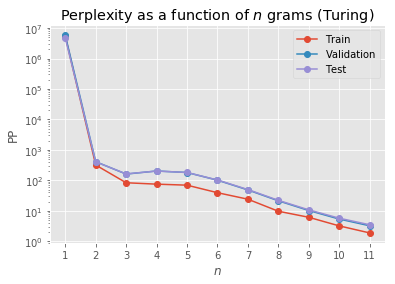

In [26]:
Nmax = 11
Nmin = 1
Ns = range(Nmin, Nmax+1)
PPs = np.zeros((Nmax-Nmin+1, 3))
for j, n in tqdm(enumerate(Ns), total=len(Ns)):
    ng = Ngram(n=n, version='turing', verbose=False)
    ng.compute_probabilities(train_new)
    perp_train = ng.compute_perplexity(train_new)
    perp_val = ng.compute_perplexity(valid_new)
    perp_test = ng.compute_perplexity(test_new)
    PPs[j] = [perp_train, perp_val, perp_test]
plt.semilogy(Ns, PPs[:, 0], marker='o', label='Train')
plt.semilogy(Ns, PPs[:, 1], marker='o', label='Validation')
plt.semilogy(Ns, PPs[:, 2], marker='o', label='Test')
plt.xticks(Ns, Ns)
plt.xlabel(r'$n$'); plt.ylabel('PP')
plt.title(r'Perplexity as a function of $n$ grams (Turing)')
plt.legend()
plt.show()

Let's generate some text on the same proposals.

In [27]:
ng1 = Ngram(n=1, version='turing', verbose=True)
ng1.compute_probabilities(train_new)
ng2 = Ngram(n=2, version='turing', verbose=True)
ng2.compute_probabilities(train_new)
ng3 = Ngram(n=3, version='turing', verbose=True)
ng3.compute_probabilities(train_new)
ng4 = Ngram(n=4, version='turing', verbose=True)
ng4.compute_probabilities(train_new)
ng5 = Ngram(n=5, version='turing', verbose=True)
ng5.compute_probabilities(train_new)
ng6 = Ngram(n=6, version='turing', verbose=True)
ng6.compute_probabilities(train_new)

Running turing 1-gram model...
Running turing 2-gram model...
Running turing 3-gram model...
Running turing 4-gram model...
Running turing 5-gram model...
Running turing 6-gram model...


In [28]:
n_next = 5
for seed_text in proposals:
    print('Input:       %s' % seed_text)
    sentence = generate_sentence(seed_text, n_next, [ng6, ng5, ng4, ng3, ng2, ng1])
    print('Predicted:   %s' % sentence)
    print('___________________________________________________\n')

Input:       he does not
Predicted:   he does not have to do that </s>
___________________________________________________

Input:       I am happy
Predicted:   I am happy to meet you </s>
___________________________________________________

Input:       I need you
Predicted:   I need you to do that for us
___________________________________________________

Input:       <s> Let s take a
Predicted:   <s> Let s take a look at this machine </s>
___________________________________________________

Input:       He used to play the
Predicted:   He used to play the <unk> </s>
___________________________________________________

Input:       Come on be
Predicted:   Come on be easy to do that </s>
___________________________________________________

Input:       <s> Do you want
Predicted:   <s> Do you want to go to </s>
___________________________________________________

Input:       He does not like
Predicted:   He does not like to be the last one
____________________________________________

<a id='Backoff'></a>

### Backoff

100%|██████████| 11/11 [01:19<00:00,  6.28s/it]


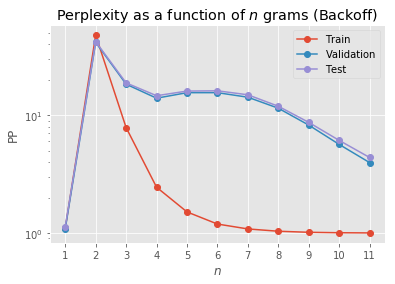

In [30]:
Nmax = 11
Nmin = 1
Ns = range(Nmin, Nmax+1)
PPs = np.zeros((Nmax-Nmin+1, 3))
for j, n in tqdm(enumerate(Ns), total=len(Ns)):
    ng = Ngram(n=n, version='backoff', verbose=False)
    ng.compute_probabilities(train_new)
    perp_train = ng.compute_perplexity(train_new)
    perp_val = ng.compute_perplexity(valid_new)
    perp_test = ng.compute_perplexity(test_new)
    PPs[j] = [perp_train, perp_val, perp_test]
plt.semilogy(Ns, PPs[:, 0], marker='o', label='Train')
plt.semilogy(Ns, PPs[:, 1], marker='o', label='Validation')
plt.semilogy(Ns, PPs[:, 2], marker='o', label='Test')
plt.xticks(Ns, Ns)
plt.xlabel(r'$n$'); plt.ylabel('PP')
plt.title(r'Perplexity as a function of $n$ grams (Backoff)')
plt.legend()
plt.show()

Let's generate some text on the same proposals.

In [49]:
ng1 = Ngram(n=1, version='backoff', verbose=True)
ng1.compute_probabilities(train_new)
ng1.compute_perplexity(train_new)
ng2 = Ngram(n=2, version='backoff', verbose=True)
ng2.compute_probabilities(train_new)
ng2.compute_perplexity(train_new)
ng3 = Ngram(n=3, version='backoff', verbose=True)
ng3.compute_probabilities(train_new)
ng3.compute_perplexity(train_new)
ng4 = Ngram(n=4, version='backoff', verbose=True)
ng4.compute_probabilities(train_new)
ng4.compute_perplexity(train_new)
ng5 = Ngram(n=5, version='backoff', verbose=True)
ng5.compute_probabilities(train_new)
ng5.compute_perplexity(train_new)
ng6 = Ngram(n=6, version='backoff', verbose=True)
ng6.compute_probabilities(train_new)
ng6.compute_perplexity(train_new)

Running backoff 1-gram model...
0 null sentence probabilities found in perplexity.
Done. Time elapsed: 5.9 sec.
Running backoff 2-gram model...
0 null sentence probabilities found in perplexity.
Done. Time elapsed: 7.0 sec.
Running backoff 3-gram model...
0 null sentence probabilities found in perplexity.
Done. Time elapsed: 8.0 sec.
Running backoff 4-gram model...
0 null sentence probabilities found in perplexity.
Done. Time elapsed: 8.2 sec.
Running backoff 5-gram model...
0 null sentence probabilities found in perplexity.
Done. Time elapsed: 8.4 sec.
Running backoff 6-gram model...
0 null sentence probabilities found in perplexity.
Done. Time elapsed: 8.5 sec.


1.1913179719453943

In [52]:
n_next = 5
for seed_text in proposals:
    print('Input:       %s' % seed_text)
    sentence = generate_sentence(seed_text, n_next, [ng6, ng5, ng4, ng3, ng2, ng1])
    print('Predicted:   %s' % sentence)
    print('___________________________________________________\n')

Input:       he does not
Predicted:   he does not think that mary really had
___________________________________________________

Input:       I am happy
Predicted:   I am happy to meet you </s>
___________________________________________________

Input:       I need you
Predicted:   I need you to do that for us
___________________________________________________

Input:       <s> Let s take a
Predicted:   <s> Let s take a look at this machine </s>
___________________________________________________

Input:       He used to play the
Predicted:   He used to play the <unk> </s>
___________________________________________________

Input:       Come on be
Predicted:   Come on be able to do that </s>
___________________________________________________

Input:       <s> Do you want
Predicted:   <s> Do you want to go to </s>
___________________________________________________

Input:       He does not like
Predicted:   He does not like to be the last one
______________________________________

<a id='Kneser-Ney'></a>

### Kneser-Ney

Here k=5.

100%|██████████| 11/11 [02:04<00:00, 11.05s/it]


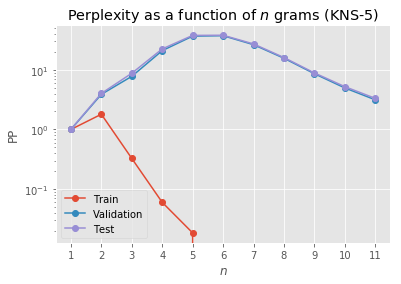

In [54]:
Nmax = 11
Nmin = 1
Ns = range(Nmin, Nmax+1)
PPs = np.zeros((Nmax-Nmin+1, 3))
for j, n in tqdm(enumerate(Ns), total=len(Ns)):
    ng = Ngram(n=n, version='kns-5', verbose=False)
    ng.compute_probabilities(train_new)
    perp_train = ng.compute_perplexity(train_new)
    perp_val = ng.compute_perplexity(valid_new)
    perp_test = ng.compute_perplexity(test_new)
    PPs[j] = [perp_train, perp_val, perp_test]
plt.semilogy(Ns, PPs[:, 0], marker='o', label='Train')
plt.semilogy(Ns, PPs[:, 1], marker='o', label='Validation')
plt.semilogy(Ns, PPs[:, 2], marker='o', label='Test')
plt.xticks(Ns, Ns)
plt.xlabel(r'$n$'); plt.ylabel('PP')
plt.title(r'Perplexity as a function of $n$ grams (KNS-5)')
plt.legend()
plt.show()

Let's generate some text on the same proposals.

In [56]:
n_next = 5
for seed_text in proposals:
    print('Input:       %s' % seed_text)
    sentence = generate_sentence(seed_text, n_next, [ng6, ng5, ng4, ng3, ng2, ng1])
    print('Predicted:   %s' % sentence)
    print('___________________________________________________\n')

Input:       he does not
Predicted:   he does not think that mary really had
___________________________________________________

Input:       I am happy
Predicted:   I am happy about your good luck </s>
___________________________________________________

Input:       I need you
Predicted:   I need you to tell me what i
___________________________________________________

Input:       <s> Let s take a
Predicted:   <s> Let s take a step back </s>
___________________________________________________

Input:       He used to play the
Predicted:   He used to play the <unk> </s>
___________________________________________________

Input:       Come on be
Predicted:   Come on be able to do that </s>
___________________________________________________

Input:       <s> Do you want
Predicted:   <s> Do you want to go back to australia
___________________________________________________

Input:       He does not like
Predicted:   He does not like to sing sad songs </s>
__________________________

On `wiki` now.

In [52]:
dataset = 'wiki'
train, test, valid = utils.read_split(dataset)
train_new, test_new, valid_new = utils.clean_text(train), utils.clean_text(test), utils.clean_text(valid)

ng1 = Ngram(n=1, version='kns-5', verbose=True)
ng1.compute_probabilities(train_new)
ng2 = Ngram(n=2, version='kns-5', verbose=True)
ng2.compute_probabilities(train_new)
ng3 = Ngram(n=3, version='kns-5', verbose=True)
ng3.compute_probabilities(train_new)
ng4 = Ngram(n=4, version='kns-5', verbose=True)
ng4.compute_probabilities(train_new)
ng5 = Ngram(n=5, version='kns-5', verbose=True)
ng5.compute_probabilities(train_new)
ng6 = Ngram(n=6, version='kns-5', verbose=True)
ng6.compute_probabilities(train_new)

Loading wiki data set...
Number of training sentences:        60000
Number of validation sentences:       3000
Number of testing sentences:          3000
Done.
Running kns-5 1-gram model...
Running kns-5 2-gram model...
Running kns-5 3-gram model...
Running kns-5 4-gram model...
Running kns-5 5-gram model...
Running kns-5 6-gram model...


In [53]:
n_next = 5
for seed_text in proposals:
    print('Input:       %s' % seed_text)
    sentence = generate_sentence(seed_text, n_next, [ng6, ng5, ng4, ng3, ng2, ng1])
    print('Predicted:   %s' % sentence)
    print('___________________________________________________\n')

Input:       he does not
Predicted:   he does not or if the president does
___________________________________________________

Input:       I am happy
Predicted:   I am happy with his win following the
___________________________________________________

Input:       I need you
Predicted:   I need you can help wikipedia by adding
___________________________________________________

Input:       <s> Let s take a
Predicted:   <s> Let s take a <unk> after the xxxx commonwealth
___________________________________________________

Input:       He used to play the
Predicted:   He used to play the role of bond only once
___________________________________________________

Input:       Come on be
Predicted:   Come on be <unk> </s>
___________________________________________________

Input:       <s> Do you want
Predicted:   <s> Do you want came from no angel xxxx
___________________________________________________

Input:       He does not like
Predicted:   He does not like it as much as she


<a id='Tuning and comparison'></a>

## Tuning and comparison

<a id='Validation set'></a>

### Validation set

First on `tatoeba`.

In [18]:
dataset = 'tatoeba'
train, test, valid = utils.read_split(dataset)
train_new, test_new, valid_new = utils.clean_text(train), utils.clean_text(test), utils.clean_text(valid)

Loading tatoeba data set...
Number of training sentences:        50000
Number of validation sentences:       5000
Number of testing sentences:          5000
Done.


Fitting 2-gram models...
Perplexities: classical: 1646.9 | add-1: 207.8 | add-2: 289.5 | backoff: 41.5 | turing: 410.3 | kns-2: 7.8 | kns-3: 5.8 | kns-4: 4.6 | kns-5: 3.9
Done. Time elapsed: 26.1 sec.
Fitting 3-gram models...
Perplexities: classical: 111.6 | add-1: 444.4 | add-2: 611.1 | backoff: 18.3 | turing: 160.5 | kns-2: 19.3 | kns-3: 13.3 | kns-4: 9.9 | kns-5: 7.8
Done. Time elapsed: 44.0 sec.
Fitting 4-gram models...
Perplexities: classical: 102.4 | add-1: 455.5 | add-2: 548.1 | backoff: 13.9 | turing: 202.5 | kns-2: 46.7 | kns-3: 33.8 | kns-4: 26.0 | kns-5: 21.0
Done. Time elapsed: 52.8 sec.
Fitting 5-gram models...
Perplexities: classical: 106.8 | add-1: 281.1 | add-2: 308.5 | backoff: 15.5 | turing: 180.8 | kns-2: 67.8 | kns-3: 52.9 | kns-4: 43.3 | kns-5: 36.7
Done. Time elapsed: 58.4 sec.
Fitting 6-gram models...
Perplexities: classical: 73.7 | add-1: 129.6 | add-2: 135.6 | backoff: 15.5 | turing: 101.3 | kns-2: 56.5 | kns-3: 47.7 | kns-4: 41.7 | kns-5: 37.3
Done. Time elaps

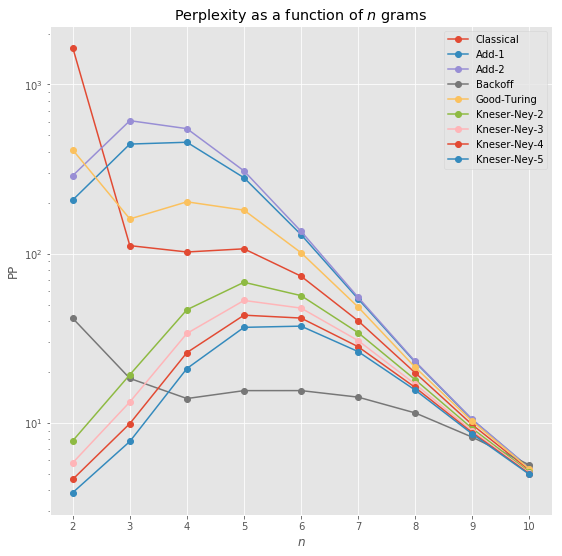

In [66]:
Nmax = 10
Ns = range(2, Nmax+1)
PPs = np.zeros((9, len(Ns)))
for j, n in enumerate(Ns):
    t0 = time()
    print('Fitting {}-gram models...'.format(n))
    for i, version in enumerate(['classical', 'add-1', 'add-2', 'backoff', 'turing', 'kns-2', 'kns-3', 'kns-4', 'kns-5']):
        ng = Ngram(n=n, version=version, verbose=False)
        ng.compute_probabilities(train_new)
        PPs[i, j] = ng.compute_perplexity(valid_new)
    print('Perplexities: classical: {:.1f} | add-1: {:.1f} | add-2: {:.1f} | backoff: {:.1f} | turing: {:.1f} | kns-2: {:.1f} | kns-3: {:.1f} | kns-4: {:.1f} | kns-5: {:.1f}'.format(PPs[0, j], PPs[1, j], PPs[2, j], PPs[3, j], PPs[4, j], PPs[5, j], PPs[6, j], PPs[7, j], PPs[8, j]))    
    print('Done. Time elapsed: {:3.1f} sec.'.format(time()-t0))
plt.figure(figsize=(9, 9))
plt.semilogy(Ns, PPs[0], marker='o', label='Classical')
plt.semilogy(Ns, PPs[1], marker='o', label='Add-1')
plt.semilogy(Ns, PPs[2], marker='o', label='Add-2')
plt.semilogy(Ns, PPs[3], marker='o', label='Backoff')
plt.semilogy(Ns, PPs[4], marker='o', label='Good-Turing')
plt.semilogy(Ns, PPs[5], marker='o', label='Kneser-Ney-2')
plt.semilogy(Ns, PPs[6], marker='o', label='Kneser-Ney-3')
plt.semilogy(Ns, PPs[7], marker='o', label='Kneser-Ney-4')
plt.semilogy(Ns, PPs[8], marker='o', label='Kneser-Ney-5')
plt.xticks(Ns, Ns)
plt.xlabel(r'$n$'); plt.ylabel('PP')
plt.title(r'Perplexity as a function of $n$ grams')
plt.legend()
plt.show()

And now on `wiki` data set.

In [22]:
dataset = 'wiki'
train, test, valid = utils.read_split(dataset)
train_new, test_new, valid_new = utils.clean_text(train), utils.clean_text(test), utils.clean_text(valid)

Loading wiki data set...
Number of training sentences:        60000
Number of validation sentences:       3000
Number of testing sentences:          3000
Done.


Fitting 2-gram models...
Perplexities: classical: 3341.7 | add-1: 384.0 | add-2: 513.0 | backoff: 57.0 | turing: 607.3 | kns-2: 8.6 | kns-3: 6.3 | kns-4: 5.0 | kns-5: 4.2
Done. Time elapsed: 65.3 sec.
Fitting 3-gram models...
Perplexities: classical: 273.3 | add-1: 1058.7 | add-2: 1378.7 | backoff: 34.3 | turing: 363.3 | kns-2: 47.5 | kns-3: 33.7 | kns-4: 25.9 | kns-5: 20.9
Done. Time elapsed: 101.9 sec.
Fitting 4-gram models...
Perplexities: classical: 397.9 | add-1: 1432.3 | add-2: 1648.1 | backoff: 37.1 | turing: 698.6 | kns-2: 210.7 | kns-3: 164.0 | kns-4: 134.2 | kns-5: 113.8
Done. Time elapsed: 148.0 sec.
Fitting 5-gram models...
Perplexities: classical: 505.3 | add-1: 1138.7 | add-2: 1223.2 | backoff: 52.0 | turing: 773.3 | kns-2: 380.0 | kns-3: 322.6 | kns-4: 282.0 | kns-5: 252.1
Done. Time elapsed: 177.1 sec.
Fitting 6-gram models...
Perplexities: classical: 445.3 | add-1: 738.4 | add-2: 769.1 | backoff: 73.3 | turing: 584.1 | kns-2: 382.4 | kns-3: 343.0 | kns-4: 313.1 | kns-5

/Users/bfiliot/Desktop/ENSAE/3A/NLP/ngram.py:238: RuntimeWarning: divide by zero encountered in log
  p += np.log(self.probabilities[ngram])


Perplexities: classical: 130.0 | add-1: 154.5 | add-2: 156.6 | backoff: 124.3 | turing: 141.0 | kns-2: 124.3 | kns-3: 119.4 | kns-4: 115.1 | kns-5: 111.3
Done. Time elapsed: 237.4 sec.
Fitting 10-gram models...
Perplexities: classical: 80.5 | add-1: 91.9 | add-2: 92.9 | backoff: 121.7 | turing: 85.3 | kns-2: 77.9 | kns-3: 75.5 | kns-4: 73.3 | kns-5: 71.3
Done. Time elapsed: 251.3 sec.


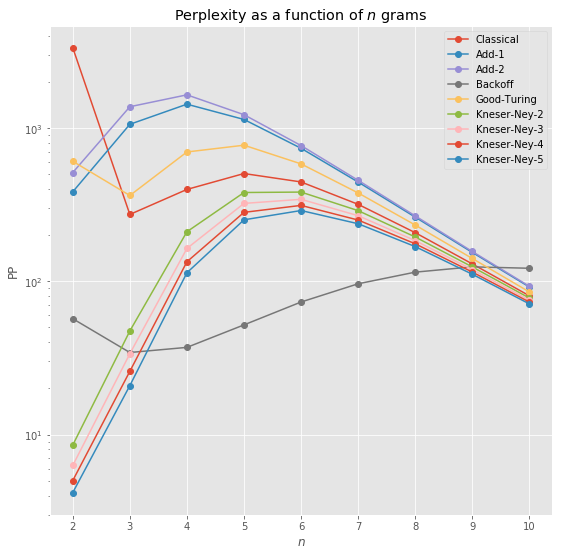

In [24]:
for j, n in enumerate(Ns):
    t0 = time()
    print('Fitting {}-gram models...'.format(n))
    for i, version in enumerate(['classical', 'add-1', 'add-2', 'backoff', 'turing', 'kns-2', 'kns-3', 'kns-4', 'kns-5']):
        ng = Ngram(n=n, version=version, verbose=False)
        ng.compute_probabilities(train_new)
        PPs[i, j] = ng.compute_perplexity(valid_new)
    print('Perplexities: classical: {:.1f} | add-1: {:.1f} | add-2: {:.1f} | backoff: {:.1f} | turing: {:.1f} | kns-2: {:.1f} | kns-3: {:.1f} | kns-4: {:.1f} | kns-5: {:.1f}'.format(PPs[0, j], PPs[1, j], PPs[2, j], PPs[3, j], PPs[4, j], PPs[5, j], PPs[6, j], PPs[7, j], PPs[8, j]))    
    print('Done. Time elapsed: {:3.1f} sec.'.format(time()-t0))
plt.figure(figsize=(9, 9))
plt.semilogy(Ns, PPs[0], marker='o', label='Classical'); plt.semilogy(Ns, PPs[1], marker='o', label='Add-1'); plt.semilogy(Ns, PPs[2], marker='o', label='Add-2'); plt.semilogy(Ns, PPs[3], marker='o', label='Backoff'); plt.semilogy(Ns, PPs[4], marker='o', label='Good-Turing'); plt.semilogy(Ns, PPs[5], marker='o', label='Kneser-Ney-2'); plt.semilogy(Ns, PPs[6], marker='o', label='Kneser-Ney-3'); plt.semilogy(Ns, PPs[7], marker='o', label='Kneser-Ney-4'); plt.semilogy(Ns, PPs[8], marker='o', label='Kneser-Ney-5')
plt.xticks(Ns, Ns); plt.xlabel(r'$n$'); plt.ylabel('PP'); plt.title(r'Perplexity as a function of $n$ grams'); plt.legend()
plt.show()

<a id='Test set'></a>

### Test set

First on `tatoeba`.

In [19]:
dataset = 'tatoeba'
train, test, valid = utils.read_split(dataset)
train_new, test_new, valid_new = utils.clean_text(train), utils.clean_text(test), utils.clean_text(valid)

Loading tatoeba data set...
Number of training sentences:        50000
Number of validation sentences:       5000
Number of testing sentences:          5000
Done.


Fitting 2-gram models...
Perplexities: classical: 1589.7 | add-1: 207.4 | add-2: 287.4 | backoff: 42.1 | turing: 404.2 | kns-2: 8.1 | kns-3: 6.0 | kns-4: 4.8 | kns-5: 4.0
Done. Time elapsed: 30.0 sec.
Fitting 3-gram models...
Perplexities: classical: 113.4 | add-1: 439.3 | add-2: 599.5 | backoff: 18.8 | turing: 162.8 | kns-2: 20.9 | kns-3: 14.8 | kns-4: 11.1 | kns-5: 8.8
Done. Time elapsed: 40.4 sec.
Fitting 4-gram models...
Perplexities: classical: 104.4 | add-1: 448.2 | add-2: 537.5 | backoff: 14.6 | turing: 202.2 | kns-2: 48.8 | kns-3: 35.7 | kns-4: 27.7 | kns-5: 22.4
Done. Time elapsed: 52.3 sec.
Fitting 5-gram models...
Perplexities: classical: 107.6 | add-1: 279.7 | add-2: 306.5 | backoff: 16.0 | turing: 181.1 | kns-2: 69.0 | kns-3: 54.1 | kns-4: 44.4 | kns-5: 37.8
Done. Time elapsed: 62.3 sec.
Fitting 6-gram models...
Perplexities: classical: 74.7 | add-1: 131.1 | add-2: 137.2 | backoff: 16.1 | turing: 102.7 | kns-2: 57.4 | kns-3: 48.5 | kns-4: 42.4 | kns-5: 38.0
Done. Time elap

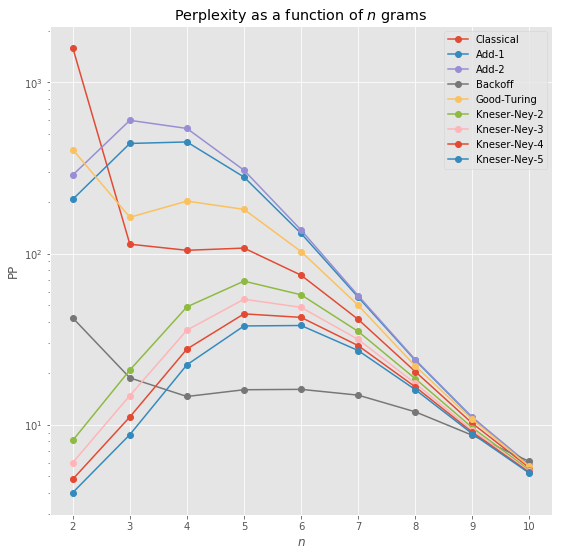

In [65]:
for j, n in enumerate(Ns):
    t0 = time()
    print('Fitting {}-gram models...'.format(n))
    for i, version in enumerate(['classical', 'add-1', 'add-2', 'backoff', 'turing', 'kns-2', 'kns-3', 'kns-4', 'kns-5']):
        ng = Ngram(n=n, version=version, verbose=False)
        ng.compute_probabilities(train_new)
        PPs[i, j] = ng.compute_perplexity(test_new)
    print('Perplexities: classical: {:.1f} | add-1: {:.1f} | add-2: {:.1f} | backoff: {:.1f} | turing: {:.1f} | kns-2: {:.1f} | kns-3: {:.1f} | kns-4: {:.1f} | kns-5: {:.1f}'.format(PPs[0, j], PPs[1, j], PPs[2, j], PPs[3, j], PPs[4, j], PPs[5, j], PPs[6, j], PPs[7, j], PPs[8, j]))    
    print('Done. Time elapsed: {:3.1f} sec.'.format(time()-t0))
plt.figure(figsize=(9, 9))
plt.semilogy(Ns, PPs[0], marker='o', label='Classical'); plt.semilogy(Ns, PPs[1], marker='o', label='Add-1'); plt.semilogy(Ns, PPs[2], marker='o', label='Add-2'); plt.semilogy(Ns, PPs[3], marker='o', label='Backoff'); plt.semilogy(Ns, PPs[4], marker='o', label='Good-Turing'); plt.semilogy(Ns, PPs[5], marker='o', label='Kneser-Ney-2'); plt.semilogy(Ns, PPs[6], marker='o', label='Kneser-Ney-3'); plt.semilogy(Ns, PPs[7], marker='o', label='Kneser-Ney-4'); plt.semilogy(Ns, PPs[8], marker='o', label='Kneser-Ney-5')
plt.xticks(Ns, Ns); plt.xlabel(r'$n$'); plt.ylabel('PP'); plt.title(r'Perplexity as a function of $n$ grams'); plt.legend()
plt.show()

And now on `wiki` data set.

In [28]:
dataset = 'wiki'
train, test, valid = utils.read_split(dataset)
train_new, test_new, valid_new = utils.clean_text(train), utils.clean_text(test), utils.clean_text(valid)

Loading wiki data set...
Number of training sentences:        60000
Number of validation sentences:       3000
Number of testing sentences:          3000
Done.


Fitting 2-gram models...
Perplexities: classical: 3343.0 | add-1: 396.2 | add-2: 521.2 | backoff: 56.6 | turing: 624.8 | kns-2: 8.7 | kns-3: 6.4 | kns-4: 5.1 | kns-5: 4.3
Done. Time elapsed: 63.6 sec.
Fitting 3-gram models...
Perplexities: classical: 282.9 | add-1: 1070.6 | add-2: 1393.5 | backoff: 34.3 | turing: 363.0 | kns-2: 49.6 | kns-3: 35.2 | kns-4: 27.1 | kns-5: 21.8
Done. Time elapsed: 106.5 sec.
Fitting 4-gram models...
Perplexities: classical: 408.7 | add-1: 1453.8 | add-2: 1667.6 | backoff: 37.8 | turing: 720.2 | kns-2: 217.6 | kns-3: 169.7 | kns-4: 139.2 | kns-5: 118.2
Done. Time elapsed: 146.6 sec.
Fitting 5-gram models...
Perplexities: classical: 525.7 | add-1: 1155.5 | add-2: 1236.1 | backoff: 53.5 | turing: 805.4 | kns-2: 395.8 | kns-3: 336.5 | kns-4: 294.9 | kns-5: 264.4
Done. Time elapsed: 169.2 sec.
Fitting 6-gram models...
Perplexities: classical: 469.9 | add-1: 749.1 | add-2: 776.4 | backoff: 75.7 | turing: 613.9 | kns-2: 402.8 | kns-3: 362.5 | kns-4: 332.3 | kns-5

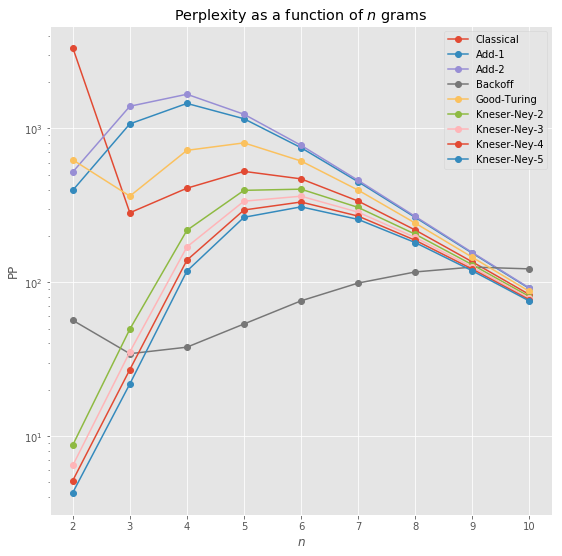

In [29]:
for j, n in enumerate(Ns):
    t0 = time()
    print('Fitting {}-gram models...'.format(n))
    for i, version in enumerate(['classical', 'add-1', 'add-2', 'backoff', 'turing', 'kns-2', 'kns-3', 'kns-4', 'kns-5']):
        ng = Ngram(n=n, version=version, verbose=False)
        ng.compute_probabilities(train_new)
        PPs[i, j] = ng.compute_perplexity(test_new)
    print('Perplexities: classical: {:.1f} | add-1: {:.1f} | add-2: {:.1f} | backoff: {:.1f} | turing: {:.1f} | kns-2: {:.1f} | kns-3: {:.1f} | kns-4: {:.1f} | kns-5: {:.1f}'.format(PPs[0, j], PPs[1, j], PPs[2, j], PPs[3, j], PPs[4, j], PPs[5, j], PPs[6, j], PPs[7, j], PPs[8, j]))    
    print('Done. Time elapsed: {:3.1f} sec.'.format(time()-t0))
plt.figure(figsize=(9, 9))
plt.semilogy(Ns, PPs[0], marker='o', label='Classical'); plt.semilogy(Ns, PPs[1], marker='o', label='Add-1'); plt.semilogy(Ns, PPs[2], marker='o', label='Add-2'); plt.semilogy(Ns, PPs[3], marker='o', label='Backoff'); plt.semilogy(Ns, PPs[4], marker='o', label='Good-Turing'); plt.semilogy(Ns, PPs[5], marker='o', label='Kneser-Ney-2'); plt.semilogy(Ns, PPs[6], marker='o', label='Kneser-Ney-3'); plt.semilogy(Ns, PPs[7], marker='o', label='Kneser-Ney-4'); plt.semilogy(Ns, PPs[8], marker='o', label='Kneser-Ney-5')
plt.xticks(Ns, Ns); plt.xlabel(r'$n$'); plt.ylabel('PP'); plt.title(r'Perplexity as a function of $n$ grams'); plt.legend()
plt.show()

The following table sums up the perplexities obtained on both test sets. Normal script: `tatoeba`, parenthesis: `wiki`.

| Models \ n  | 2           | 3          | 4          | 5          |
|-------------|-------------|------------|------------|------------|
| Classic     | 1589 (3343) | 113 (282)  | 104 (409)  | 108 (526)  |
| Add-1       | 207 (396)   | 439 (1071) | 448 (1454) | 280 (1155) |
| Add-2       | 287 (521)   | 600 (1394) | 538 (1668) | 307 (1236) |
| Backoff     | 42 (57)     | 19 (34)    | 15 (38)    | 16 (54)    |
| Good_Turing | 404 (624)   | 163 (363)  | 202 (720)  | 181 (805)  |
| KSN-2       | 8 (9)       | 21 (50)    | 50 (218)   | 69 (395)   |
| KSN-3       | 6 (6)       | 15 (35)    | 36 (170)   | 54 (336)   |
| KSN-4       | 5 (5)       | 11 (27)    | 28 (140)   | 44 (295)   |
| KSN-5       | 4 (4)       | 9 (22)     | 22 (118)   | 39 (264)   |

<a id='Text generation'></a>

<a id='Deeper LM models'></a>

# Deeper LM models

If you want to load pre-trained embeddings from FastText.

In [8]:
add_embedding = False
path_to_embeddings = './'
if add_embedding:
    w = utils.load_vectors(os.path.join(path_to_embeddings, 'wiki.en.vec'), nmax=2*10**6)
    pre_trained = True
else:
    w = None
    pre_trained = False

100%|█████████▉| 1999995/2000000 [04:48<00:00, 6920.48it/s]


Loaded 1999995 pretrained word vectors


<a id='Testing some architectures'></a>

## Testing some architectures

Tokenizing...
Creating n-grams...
Split into X and y...
Done. Time elapsed: 5.4 sec.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 3, 10)             29870     
_________________________________________________________________
dropout_5 (Dropout)          (None, 3, 10)             0         
_________________________________________________________________
bidirectional_3 (Bidirection (None, 32)                3456      
_________________________________________________________________
dropout_6 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 2987)              98571     
Total params: 131,897
Trainable params: 131,897
Non-trainable params: 0
_________________________________________________________________
None
Train on 308731 samples, validate on 30495 sam

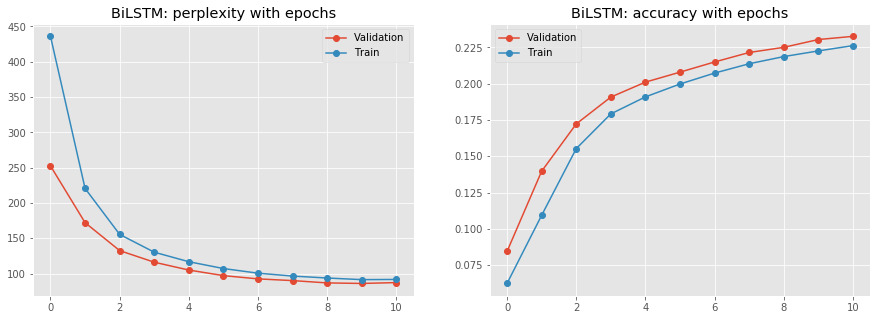

In [26]:
######################################################### SETUP ##########################################################
# Parameters
ngram = 4
dropout_rate1 = 0
dropout_rate2 = 0.2
embedding = 10
memorycells = 16
epochs=50
batch_size = 256

# Type of recurrent layer
recurrent_layer = 'bilstm'

# Which loss to monitor ('val_keras_perplexity' or 'val_acc')
monitor='val_keras_perplexity'

# Optimizer
solver= keras.optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)

###################################################### PREPROCESSING ######################################################

# First, clean the data and format it with utils.keras_preprocess
# Add pre-embedding (or not)
preprocessing = utils.keras_preprocess(train_new, valid_new, test_new, ngram=ngram)
preprocessing.word2vec = w
X_train, X_valid, X_test, y_train, y_valid, y_test = preprocessing.output()

# Then, set model name and filepath to save weights, architectures and results
modelname = dataset+'_'+recurrent_layer+'_ngram{:d}_emb{:d}_mcells{:d}_batch{:d}_ep{:d}_dropout{:0.1f}'.format(ngram, embedding, memorycells, batch_size, epochs, dropout_rate2)

# And finally, callbacks
patience = 0
callbacks = [
    keras.callbacks.EarlyStopping(monitor=monitor, min_delta=0, patience=patience, verbose=0, mode='min', restore_best_weights=True),
    keras.callbacks.ModelCheckpoint(filepath=filepath, monitor=monitor, verbose=0, save_best_only=True),
    LrReducer(patience=patience, reduce_rate=10, reduce_nb=4, monitor=monitor, verbose=1)
]

######################################################### TRAINING #########################################################

# Init model (__init__ call)
model = RecDeepNetworks(preprocessing, modelname=modelname, verbose=0)

# Second init (parameters + architecture) (can add some with **kwargs)
model._init(recurrent_layer=recurrent_layer,
            pre_trained=pre_trained,
            embedding=embedding,
            memorycells=memorycells,
            dropout_rate1=dropout_rate1,
            dropout_rate2=dropout_rate2)

# Compile
model._compile(loss='sparse_categorical_crossentropy', optimizer=solver)

# Train
model._fit(batch_size=batch_size, epochs=epochs, monitor=monitor, patience=1, verbose=1, callbacks=callbacks)

# Save weights and architectures
model._save()

# Evaluate on train, test and validation set
model._print_results()

# Plot results
model._plot_results(modelname='BiLSTM')

<a id='Tuning'></a>

## Tuning

This part on tuning aims at showing the influence of 4 main parameters on the accuracy (in predicting the next word) and the perplexity: length of $n$-grams (`ngram`), the size of embedding space (`embedding`), the number of memory cells in recurrent layers (`memorycells`) and the dropout rate at the end of the networks (`dropout_rate2`). 

Some other parameters have not been tuned yet: the dropout rate at the beginning of the networks (`dropout_rate1`), the batch-size (`batch_size`). 

In [ ]:
####################################################### FIXED SETUP ########################################################
dataset = 'tatoeba'
dropout_rate1 = 0
epochs=50
batch_size = 256 # speed up computations
solver = keras.optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
recurrent_layer = 'rnn'
monitor='val_keras_perplexity'

####################################################### FINE-TUNING #######################################################

# In order not to reprocess the data at each iteration of grid-searching, one use n_gram_old and n_gram_new
ngram_old = 2
ngram = ngram_old
# Preprocessing
preprocessing = utils.keras_preprocess(train_new, valid_new, test_new, ngram=ngram)
X_train, X_valid, X_test, y_train, y_valid, y_test = preprocessing.output()

# Let's start
for ngram, embedding, memorycells, dropout_rate2 in itertools.product([2, 3, 4, 5],
                                                                      [10, 50, 100, 200],
                                                                      [32, 64, 128, 256],
                                                                      [0, 0.3]):
    
    # Preprocessing
    ngram_new = ngram
    if ngram_new != ngram_old:
        # Re-process the data if ngram += 1
        preprocessing = utils.keras_preprocess(train_new, valid_new, test_new, ngram=ngram)
        X_train, X_valid, X_test, y_train, y_valid, y_test = preprocessing.output()
    ngram_old = ngram
    
    # Set model name and filepath
    modelname = dataset+'_'+recurrent_layer+'_ngram{:d}_emb{:d}_mcells{:d}_batch{:d}_ep{:d}_dropout{:0.1f}'.format(ngram, embedding, memorycells, batch_size, epochs, dropout_rate2)
    filepath = os.path.join('./Checkpoints/', modelname+'--weights.e{epoch:02d}-perp{val_keras_perplexity:.2f}.hdf5')
    print(modelname)
    
    # Init instance
    model = RecDeepNetworks(preprocessing, modelname=modelname, verbose=0)
    
    # Define callbacks
    callbacks = [
        keras.callbacks.EarlyStopping(monitor=monitor, min_delta=0, patience=0, verbose=0, mode='min', restore_best_weights=True),
        #keras.callbacks.ModelCheckpoint(filepath=filepath, monitor=monitor, verbose=0, save_best_only=True)
        #reccurentNets.LrReducer(patience=0, reduce_rate=10, reduce_nb=4, monitor=monitor, verbose=1)
    ]
    
    
    # Define architecture
    model._init(recurrent_layer=recurrent_layer,
              pre_trained=False,
              embedding=embedding,
              memorycells=memorycells,
              dropout_rate1=dropout_rate1,
              dropout_rate2=dropout_rate2)
    
    # Compile
    model._compile(loss='sparse_categorical_crossentropy', optimizer=solver)
    
    # Train
    model._fit(batch_size=batch_size, epochs=epochs, monitor=monitor, patience=1, verbose=1, callbacks=callbacks)
    
    # Save (not necessary to save resources)
    #model._save()
    
    # Evaluate on train, val and test sets (and save results!)
    model._print_results()

<a id='Comparison'></a>

<a id='LSTM'></a>

### LSTM

As we firstly made some experiments with LSTMs, we first load the results. The procedure is a bit heavy but works fine at the end. 

In [3]:
results = utils.load_results('lstm')
results.head()

Loading 166 results for lstm...


,dataset,layer,ngram,embedding,mcells,batchsize,dropout2,loss_train,per_train,acc_train,loss_val,per_val,acc_val,loss_test,per_test,acc_test
1,tatoeba,lstm,2.0,100.0,64.0,256.0,0.0,4.298340,88.318486,0.210981,4.328201,91.534733,0.204011,4.379140,97.663292,0.204758
2,tatoeba,lstm,5.0,200.0,256.0,256.0,0.0,3.593139,44.215947,0.314549,3.971386,69.587520,0.273583,4.034422,74.489913,0.271049
3,tatoeba,lstm,3.0,10.0,16.0,256.0,0.3,4.611957,125.038316,0.207541,4.630320,128.065792,0.202885,4.685998,139.386881,0.201724
4,tatoeba,lstm,10.0,100.0,128.0,256.0,0.0,3.744599,51.059296,0.305277,4.241650,91.502600,0.268050,4.372778,108.235718,0.255241
5,tatoeba,lstm,10.0,100.0,256.0,256.0,0.0,3.562389,43.138438,0.326132,4.178448,87.946239,0.277842,4.321933,104.775844,0.260812


Now let's display some statistics on the perplexity.

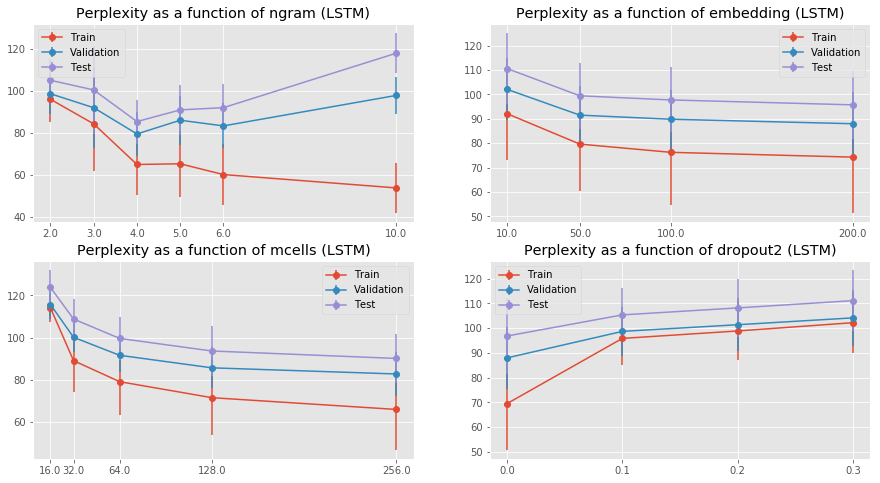

In [4]:
plt.figure(figsize=(15, 8))
for j, param in enumerate(['ngram', 'embedding', 'mcells', 'dropout2']):
    plt.subplot(2, 2, j+1)
    utils.plot_comp(results, param, 'LSTM', 'per')
plt.show()

And for accuracy in predicting the next word.

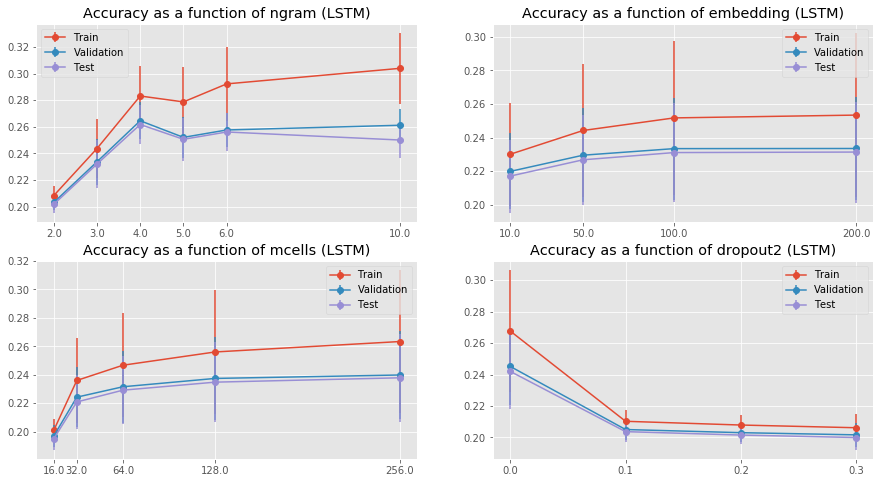

In [6]:
plt.figure(figsize=(15, 8))
for j, param in enumerate(['ngram', 'embedding', 'mcells', 'dropout2']):
    plt.subplot(2, 2, j+1)
    utils.plot_comp(results, param, 'LSTM', 'acc')
plt.show()

Now, we display and select the best model (minimal perplexity on validation set) along with its parameter. 

In [8]:
best_lstm = results[results['per_val'] == np.min(results['per_val'])]
best_lstm

,dataset,layer,ngram,embedding,mcells,batchsize,dropout2,loss_train,per_train,acc_train,loss_val,per_val,acc_val,loss_test,per_test,acc_test
158,tatoeba,lstm,4.0,200.0,256.0,256.0,0.0,3.476416,39.563023,0.327455,3.869862,64.124404,0.286561,3.937989,70.345284,0.286694


Here is the history of the best lstm.

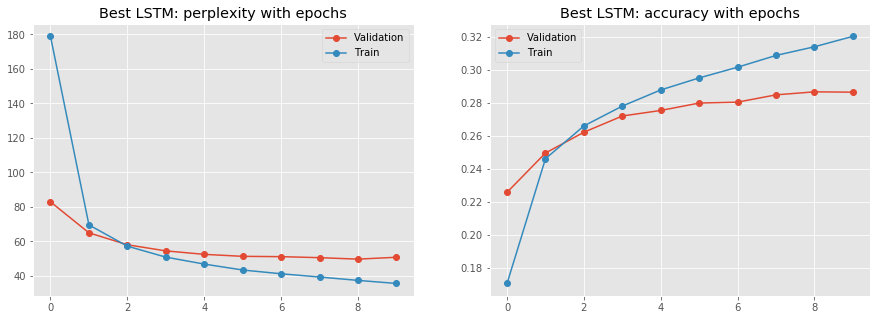

In [248]:
# model._plot_results(modelname='Best LSTM')

<a id='BiLSTM'></a>

### BiLSTM

As the previous experiments took a long time to run, even on GPU's with batch size set to 256, we restricted the following ones in exploring a bit less the parameters space. As a consequence, we rather choose to tune parameters accross the following sets:
- `ngram`: ------- {2, 3, 4, 5, 6}
- `embedding`: -- {10, 50, 100, 200}
- `mcells`: ------ {32, 64, 128, 256}
- `dropout`: ----- {0, 0.4}

Loading 80 results for cudnnbilstm...


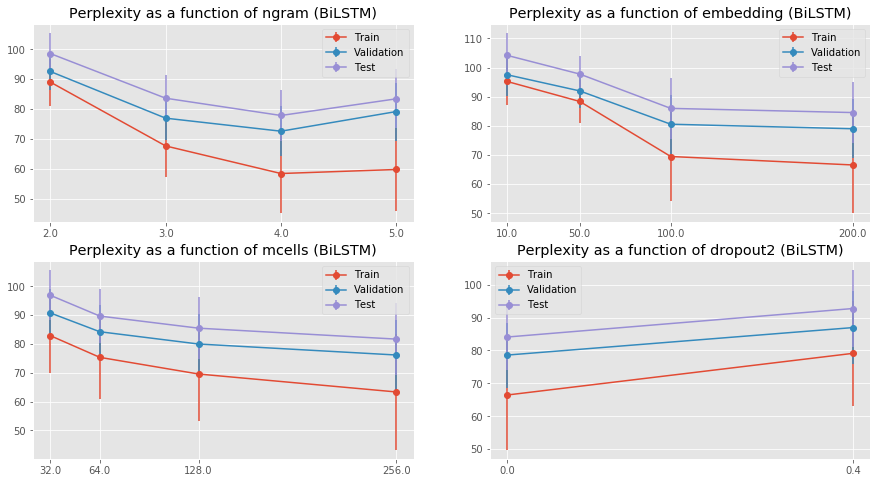

In [10]:
results = utils.load_results('cudnnbilstm')
plt.figure(figsize=(15, 8))
for j, param in enumerate(['ngram', 'embedding', 'mcells', 'dropout2']):
    plt.subplot(2, 2, j+1)
    utils.plot_comp(results, param, 'BiLSTM', 'per')
plt.show()

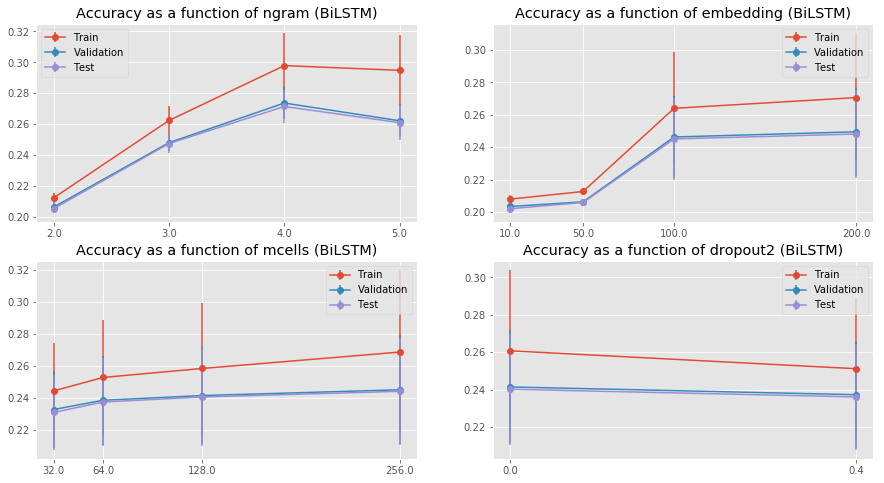

In [11]:
plt.figure(figsize=(15, 8))
for j, param in enumerate(['ngram', 'embedding', 'mcells', 'dropout2']):
    plt.subplot(2, 2, j+1)
    utils.plot_comp(results, param, 'BiLSTM', 'acc')
plt.show()

In [12]:
best_bilstm = results[results['per_val'] == np.min(results['per_val'])]
best_bilstm

,dataset,layer,ngram,embedding,mcells,batchsize,dropout2,loss_train,per_train,acc_train,loss_val,per_val,acc_val,loss_test,per_test,acc_test
75,tatoeba,cudnnbilstm,4.0,200.0,256.0,256.0,0.0,3.365399,34.897371,0.341773,3.833577,61.384786,0.290408,3.904856,67.782929,0.284638


<a id='GRU'></a>

### Gated Recurrent Units Network

Loading 128 results for cudnngru...


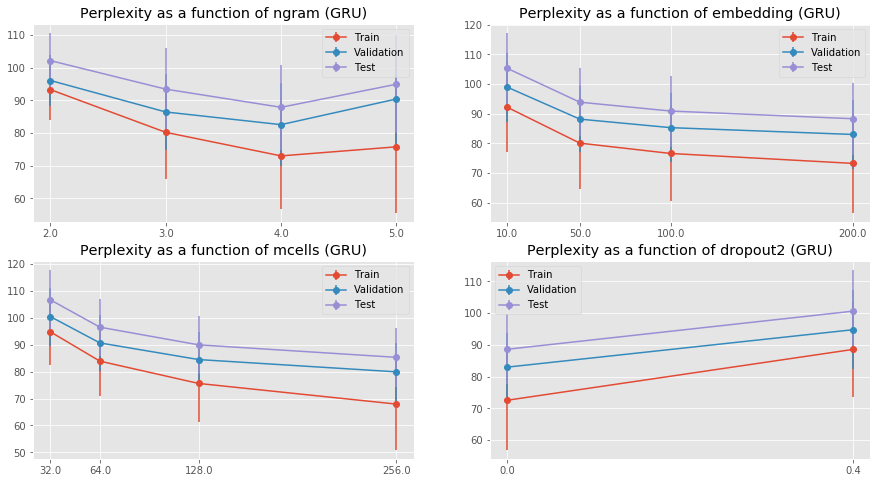

In [18]:
results = utils.load_results('cudnngru')
plt.figure(figsize=(15, 8))
for j, param in enumerate(['ngram', 'embedding', 'mcells', 'dropout2']):
    plt.subplot(2, 2, j+1)
    utils.plot_comp(results, param, 'GRU', 'per')
plt.show()

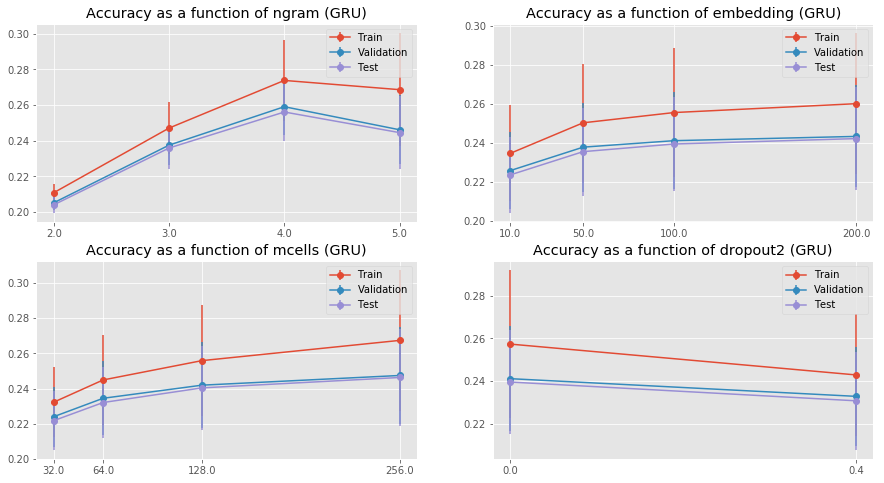

In [19]:
plt.figure(figsize=(15, 8))
for j, param in enumerate(['ngram', 'embedding', 'mcells', 'dropout2']):
    plt.subplot(2, 2, j+1)
    utils.plot_comp(results, param, 'GRU', 'acc')
plt.show()

In [20]:
best_gru = results[results['per_val'] == np.min(results['per_val'])]
best_gru

,dataset,layer,ngram,embedding,mcells,batchsize,dropout2,loss_train,per_train,acc_train,loss_val,per_val,acc_val,loss_test,per_test,acc_test
55,tatoeba,cudnngru,4.0,200.0,256.0,256.0,0.0,3.582823,43.714909,0.318886,3.874199,61.695218,0.28726,3.936932,66.667479,0.284095


<a id='Feed forward'></a>

### Feed forward

Loading 100 results for ffnn...


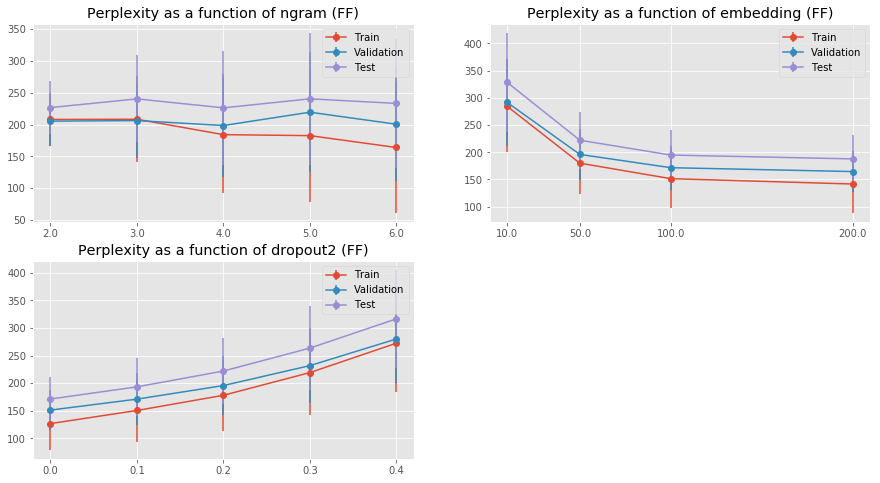

In [54]:
results = utils.load_results('ffnn')
plt.figure(figsize=(15, 8))
for j, param in enumerate(['ngram', 'embedding', 'dropout2']):
    plt.subplot(2, 2, j+1)
    utils.plot_comp(results, param, 'FF', 'per')
plt.show()

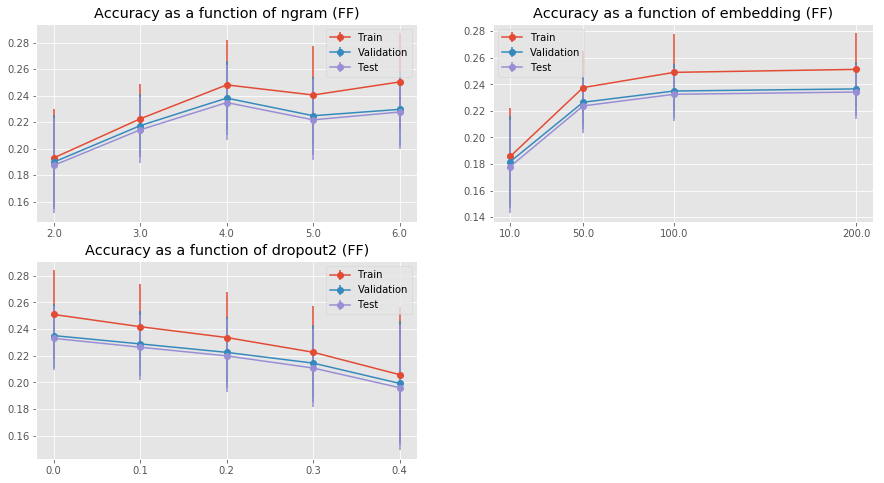

In [55]:
plt.figure(figsize=(15, 8))
for j, param in enumerate(['ngram', 'embedding', 'dropout2']):
    plt.subplot(2, 2, j+1)
    utils.plot_comp(results, param, 'FF', 'acc')
plt.show()

In [50]:
best_ffnn = results[results['per_val'] == np.min(results['per_val'])]
best_ffnn

,dataset,layer,ngram,embedding,mcells,batchsize,dropout2,loss_train,per_train,acc_train,loss_val,per_val,acc_val,loss_test,per_test,acc_test
31,tatoeba,ffnn,4.0,200.0,0.0,256.0,0.0,3.95191,74.738595,0.288659,4.222101,104.743162,0.267978,4.305607,116.911847,0.265511


<a id='RNN'></a>

### Recurrent Neural Network

Loading 131 results for rnn...


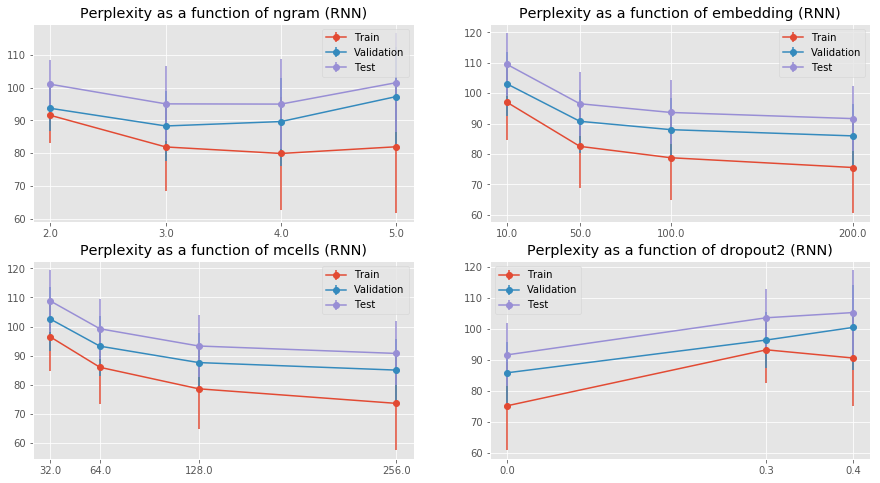

In [3]:
results = utils.load_results('rnn')
plt.figure(figsize=(15, 8))
for j, param in enumerate(['ngram', 'embedding', 'mcells', 'dropout2']):
    plt.subplot(2, 2, j+1)
    utils.plot_comp(results, param, 'RNN', 'per')
plt.show()

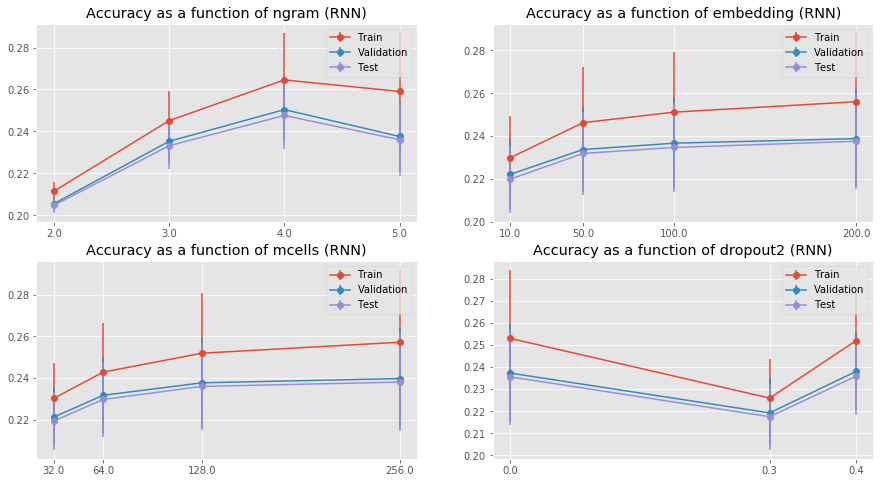

In [4]:
plt.figure(figsize=(15, 8))
for j, param in enumerate(['ngram', 'embedding', 'mcells', 'dropout2']):
    plt.subplot(2, 2, j+1)
    utils.plot_comp(results, param, 'RNN', 'acc')
plt.show()

In [5]:
best_rnn = results[results['per_val'] == np.min(results['per_val'])]
best_rnn

,dataset,layer,ngram,embedding,mcells,batchsize,dropout2,loss_train,per_train,acc_train,loss_val,per_val,acc_val,loss_test,per_test,acc_test
106,tatoeba,rnn,4.0,200.0,256.0,256.0,0.0,3.660331,47.217109,0.309538,3.945377,66.465276,0.274209,4.001106,71.097278,0.274962


<a id='Bilstmconv2D'></a>

### 2D Convolutional BiLSTM 

Implementation of BLSTM2DCNN : Peng et al. (2016), "Text Classification Improved by Integrating Bidirectional LSTM with Two-dimensional Max Pooling".

Because this architecture does have millions of parameters, we only restrict our fine-tuning to `ngram=4`.

Loading 45 results for bilstmconv2D...


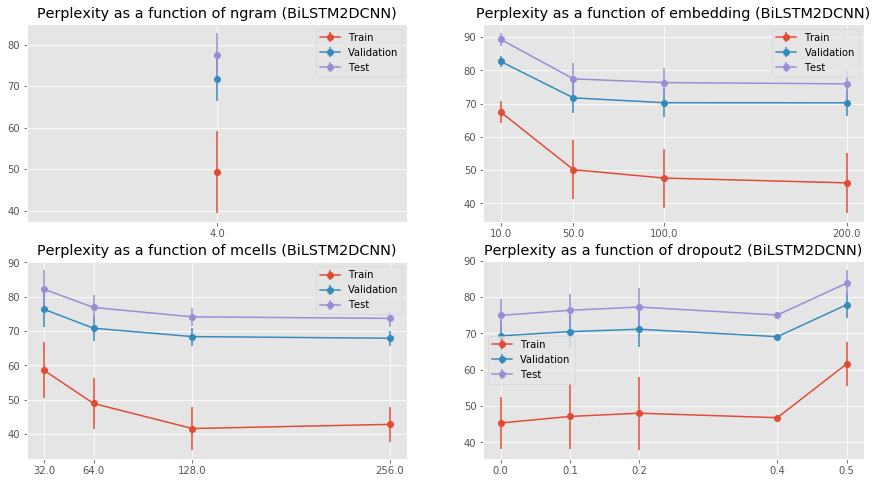

In [20]:
results = utils.load_results('bilstmconv2D')
plt.figure(figsize=(15, 8))
for j, param in enumerate(['ngram', 'embedding', 'mcells', 'dropout2']):
    plt.subplot(2, 2, j+1)
    utils.plot_comp(results, param, 'BiLSTM2DCNN', 'per')
plt.show()

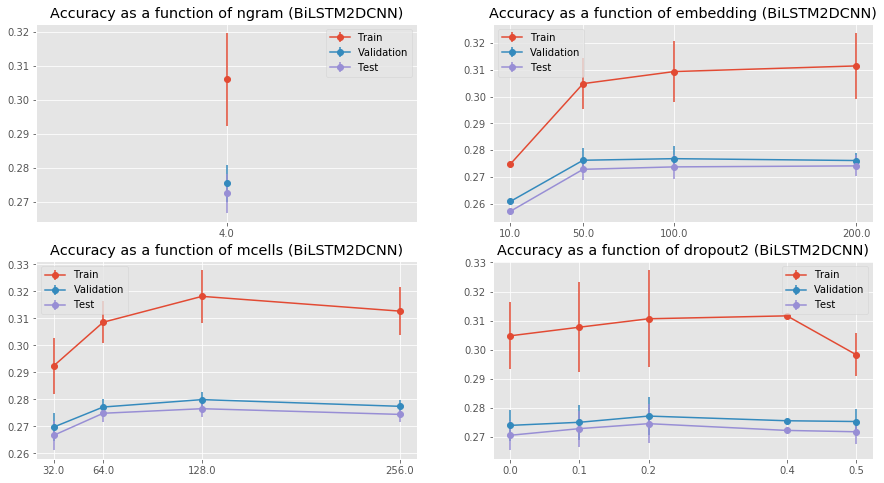

In [21]:
plt.figure(figsize=(15, 8))
for j, param in enumerate(['ngram', 'embedding', 'mcells', 'dropout2']):
    plt.subplot(2, 2, j+1)
    utils.plot_comp(results, param, 'BiLSTM2DCNN', 'acc')
plt.show()

In [14]:
best_bilstmconv2D = results[results['per_val'] == np.min(results['per_val'])]
best_bilstmconv2D

,dataset,layer,ngram,embedding,mcells,batchsize,dropout2,loss_train,per_train,acc_train,loss_val,per_val,acc_val,loss_test,per_test,acc_test
12,tatoeba,bilstmconv2D,4.0,200.0,256.0,256.0,0.0,3.586067,43.001702,0.304207,3.950393,66.237355,0.274341,4.008662,70.800182,0.270696


<a id='Impact of parameters'></a>

## Impact of pre-embedding, batch size, dropout and more memory cells

Now that we've selected the best models based on the perplexity on validation set, we want to explore more parameters. This allows us to save computational resources (we could have done it before, but it would have been too long, and Colab always disconnect after some time...). 

To this extent, we wish to investigate the role of pre-embedding, batch size and more memory cells.

First, we recall the best models for each type of recurrent network (or feed forward).

Before, let's make a summary of the performance of our models on `tatoeba` dataset:


| Models       | Train acc. | Val acc. | Test acc. | Train PP. | Val PP. | Test PP. |
|--------|------------|----------|-----------|-----------|---------|----------|
| LSTM   | 32.7%     |   28.7% |   28.7%  |  39.6    |  64.1  |  70.3   |
| BiLSTM |  34.2%    |  29.0%  |   28.5%  |  34.9    |  61.4  |  67.8   |
| RNN    |  31.0%    |  27.4%  |   27.5%  |  47.2    |  66.5  |  71.1   |
| GRU    |  31.9%    |  28.7%  |   28.4%  |  43.7    |  61.7  |  66.7   |
| FF     |  28.9%    |  26.8%  |   26.6%  |  74.7    |  104.7  |  117.0   |
| BiLSTMCNN |  30.4%    |  27.4%  |   27.1%  |  43.0    |  66.2  |  70.8   |



Loading 8 results for lstm...


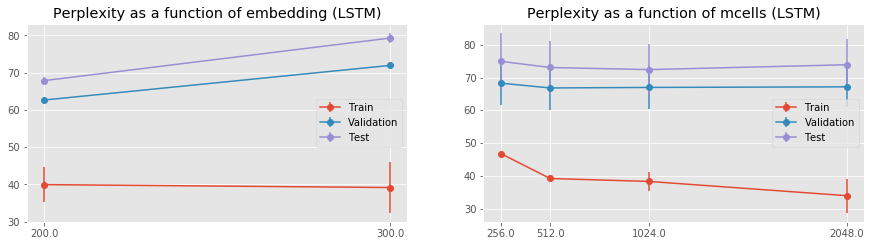

Loading 8 results for cudnnbilstm...


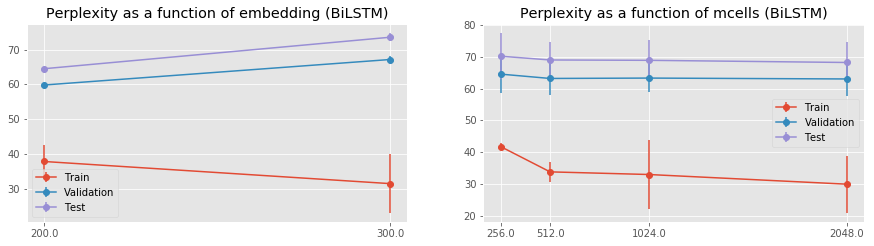

Loading 6 results for rnn...


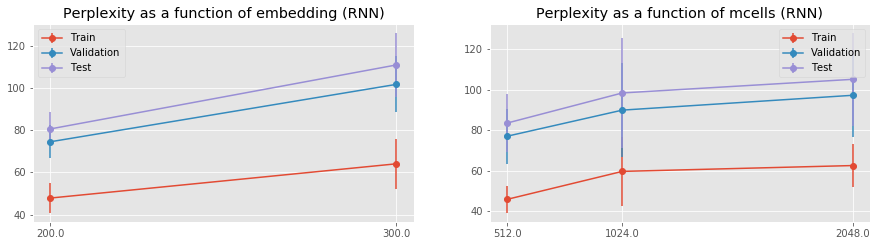

Loading 8 results for cudnngru...


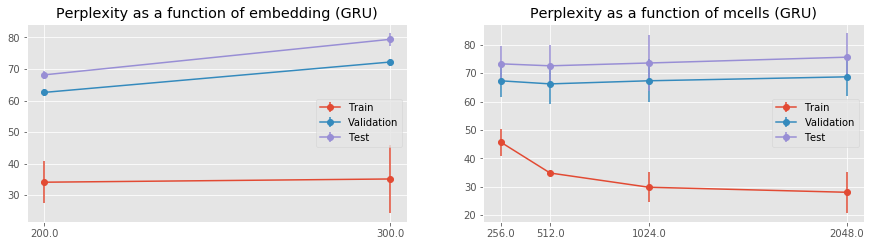

Loading 8 results for ffnn...


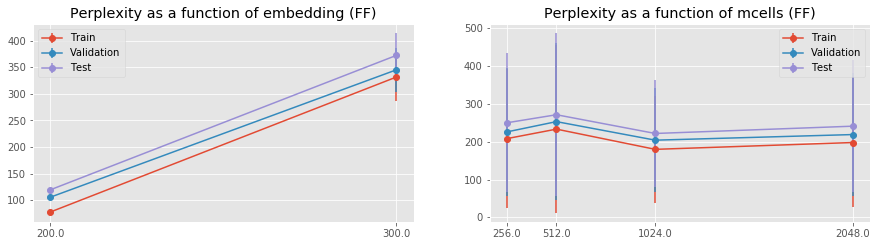

Loading 5 results for bilstmconv2D...


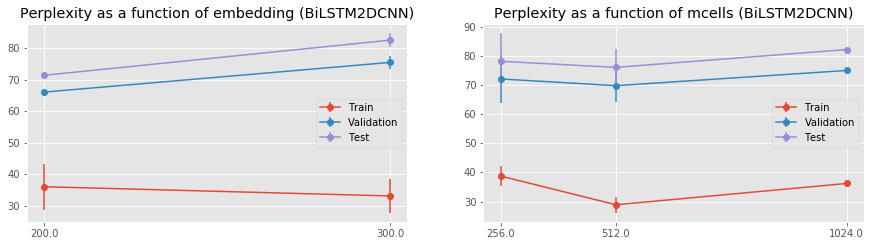

In [5]:
results_lstm = utils.load_results('lstm', best=True)
plt.figure(figsize=(15, 8))
for j, param in enumerate(['embedding', 'mcells']):
    plt.subplot(2, 2, j+1)
    utils.plot_comp(results_lstm, param, 'LSTM', 'per')
plt.show()
results_bilstm = utils.load_results('cudnnbilstm', best=True)
plt.figure(figsize=(15, 8))
for j, param in enumerate(['embedding', 'mcells']):
    plt.subplot(2, 2, j+1)
    utils.plot_comp(results_bilstm, param, 'BiLSTM', 'per')
plt.show()
results_rnn = utils.load_results('rnn', best=True)
plt.figure(figsize=(15, 8))
for j, param in enumerate(['embedding', 'mcells']):
    plt.subplot(2, 2, j+1)
    utils.plot_comp(results_rnn, param, 'RNN', 'per')
plt.show()
results_gru = utils.load_results('cudnngru', best=True)
plt.figure(figsize=(15, 8))
for j, param in enumerate(['embedding', 'mcells']):
    plt.subplot(2, 2, j+1)
    utils.plot_comp(results_gru, param, 'GRU', 'per')
plt.show()
results_ff = utils.load_results('ffnn', best=True)
plt.figure(figsize=(15, 8))
for j, param in enumerate(['embedding', 'mcells']):
    plt.subplot(2, 2, j+1)
    utils.plot_comp(results_ff, param, 'FF', 'per')
plt.show()
results_bicnn = utils.load_results('bilstmconv2D', best=True)
plt.figure(figsize=(15, 8))
for j, param in enumerate(['embedding', 'mcells']):
    plt.subplot(2, 2, j+1)
    utils.plot_comp(results_bicnn, param, 'BiLSTM2DCNN', 'per')
plt.show()

In [6]:
zo = np.zeros(6)
best_results = pd.DataFrame({'dataset': zo,'layer': zo,'ngram': zo, 'embedding': zo, 'mcells': zo, 'batchsize': zo, 'dropout2': zo,
                           'loss_train': zo, 'per_train': zo, 'acc_train': zo,
                           'loss_val': zo, 'per_val': zo, 'acc_val': zo,
                           'loss_test': zo, 'per_test': zo, 'acc_test': zo})


for j, results in enumerate([results_lstm, results_bilstm, results_rnn, results_gru, results_ff, results_bicnn]): 
    best_results.iloc[j] = results[results['per_val'] == np.min(results['per_val'])].values[0]
best_results

,dataset,layer,ngram,embedding,mcells,batchsize,dropout2,loss_train,per_train,acc_train,loss_val,per_val,acc_val,loss_test,per_test,acc_test
0,tatoeba,lstm,4.0,200.0,512.0,256.0,0.0,3.473400,39.015536,0.322041,3.859089,62.029223,0.281983,3.927686,67.447250,0.280282
1,tatoeba,cudnnbilstm,4.0,200.0,2048.0,256.0,0.0,3.410684,36.352084,0.321878,3.822951,59.226720,0.280830,3.889417,63.716188,0.278807
2,tatoeba,rnn,4.0,200.0,512.0,256.0,0.0,3.530875,41.056104,0.321497,3.951968,67.326282,0.275165,4.018090,73.437670,0.275184
3,tatoeba,cudnngru,4.0,200.0,512.0,256.0,0.0,3.375721,34.800329,0.336499,3.861802,61.190232,0.286067,3.930637,67.451439,0.282879
4,tatoeba,ffnn,4.0,200.0,2048.0,256.0,0.0,3.978641,76.523724,0.283899,4.243476,103.430903,0.262912,4.328771,118.228470,0.263033
5,tatoeba,bilstmconv2D,4.0,200.0,512.0,256.0,0.0,3.281392,30.854581,0.333939,3.930944,65.890542,0.277503,3.993924,71.558955,0.276242


<a id='Overview'></a>

## Overview

To conclude, let's compare the evolution on `tatoeba` data set with (normal) and without (parenthesis) pre-trained embeddings from Fast-Text. Blue and red colors indicate the best perplexity on test and validation respectively. 


| Models       | Train acc. | Val acc. | Test acc. | Train PP. | Val PP. | Test PP. |
|--------|------------|----------|-----------|-----------|---------|----------|
| LSTM   | 32.2% (**32.7%**)     |   28.2% (**28.7%**) |   28.0% (**28.7%**)  |  **39.0** (39.6)    |  **62.0** (64.1)  |  **67.4** (70.3)   |
| BiLSTM | 32.1%  (**34.2%**)    |  28.1% (**29.0%**)  |   27.9% (**28.5%**)  |  36.4 (**34.9**)    |  **59.2** (61.4)  |  <span style="color:blue"> **63.7** </span> (67.8)   |
| RNN    | **32.1%** (31.0%)    |  **27.5%** (27.4%)  |   27.5% (27.5%)  |  **41.1** (47.2)    |  67.3 (**66.5**)  |  73.4 (**71.1**)   |
| GRU    |  **33.6% (31.9%**)    |  28.6% (**28.7%**)  |   28.3% (**28.4%**)  |  **34.8** (43.7)    |  <span style="color:red"> **61.2** </span> (61.7)  |  67.5 (**66.7**)   |
| FF     |  28.4% (**28.9%**)    | 26.3%  (**26.8%**)  |   26.3% (**26.6%**)  |  76.5 (**74.7**)    |  **103.4** (104.7)  |  118.2 (**117.0**)   |
| BiLSTMCNN |  **33.4%** (30.4%)    |  **27.8%** (27.4%)  |   **27.6%** (27.1%)  |  **30.9** (43.0)    |  **66.0** (66.2)  |  71.6 (**70.8**)   |




And now use the best models (6 in total) architectures and train them on `wiki`data set. Next are the results:

In [15]:
results_lstm = utils.load_results('lstm', dataset='wiki', best=True)
results_bilstm = utils.load_results('cudnnbilstm', dataset='wiki', best=True)
results_rnn = utils.load_results('rnn', dataset='wiki', best=True)
results_gru = utils.load_results('cudnngru', dataset='wiki', best=True)
results_ff = utils.load_results('ffnn', dataset='wiki', best=True)
results_bicnn = utils.load_results('bilstmconv2D', dataset='wiki', best=True)

Loading 1 results for lstm...
Loading 1 results for cudnnbilstm...
Loading 1 results for rnn...
Loading 1 results for cudnngru...
Loading 1 results for ffnn...
Loading 1 results for bilstmconv2D...


In [17]:
zo = np.zeros(6)
best_results = pd.DataFrame({'dataset': zo,'layer': zo,'ngram': zo, 'embedding': zo, 'mcells': zo, 'batchsize': zo, 'dropout2': zo,
                           'loss_train': zo, 'per_train': zo, 'acc_train': zo,
                           'loss_val': zo, 'per_val': zo, 'acc_val': zo,
                           'loss_test': zo, 'per_test': zo, 'acc_test': zo})


for j, results in enumerate([results_lstm, results_bilstm, results_rnn, results_gru, results_ff, results_bicnn]): 
    best_results.iloc[j] = results[results['per_val'] == np.min(results['per_val'])].values[0]
best_results

,dataset,layer,ngram,embedding,mcells,batchsize,dropout2,loss_train,per_train,acc_train,loss_val,per_val,acc_val,loss_test,per_test,acc_test
0,wiki,lstm,4.0,200.0,512.0,256.0,0.0,4.421692,111.819599,0.284185,4.681974,155.421872,0.269136,4.686196,157.557879,0.265082
1,wiki,cudnnbilstm,4.0,200.0,2048.0,256.0,0.0,4.343609,102.876846,0.283495,4.611375,144.324361,0.265475,4.622849,145.171554,0.263461
2,wiki,rnn,4.0,200.0,512.0,256.0,0.0,4.665182,138.728520,0.260539,4.826907,172.087579,0.251395,4.837282,174.483643,0.249209
3,wiki,cudnngru,4.0,200.0,512.0,256.0,0.0,4.564427,127.166206,0.272935,4.749406,161.483161,0.263402,4.752431,162.355697,0.257904
4,wiki,ffnn,4.0,200.0,2048.0,256.0,0.0,5.577825,471.987424,0.226561,5.633051,513.328939,0.230582,5.642148,593.906206,0.222479
5,wiki,bilstmconv2D,4.0,200.0,512.0,256.0,0.0,4.279768,94.178905,0.287272,4.740880,167.090602,0.262659,4.750818,166.378752,0.259396


The results of the best models calibrated on `tatoeba` and re-trained on `wiki` are the following:

Before, let's make a summary of the performance of our models on `tatoeba` dataset. Still, blue and red colors indicate the best perplexity on test and validation respectively. 


| Models       | Train acc. | Val acc. | Test acc. | Train PP. | Val PP. | Test PP. |
|--------|------------|----------|-----------|-----------|---------|----------|
| LSTM   | 28.4%     |   26.9% |   26.5%  |  111.8    |  155.4  |  157.6   |
| BiLSTM |  28.3%    |  26.5%  |   26.3%  |  102.9    |  <span style="color:red"> 144.3 </span>  |  <span style="color:blue"> 145.2 </span>   |
| RNN    |  26.1%    |  25.1%  |   24.9%  |  138.7    |  172.1  |  174.5   |
| GRU    |  27.3%    |  26.3%  |   25.7%  |  127.2    |  161.5  |  162.4   |
| FF     |  22.7%    |  23.1%  |   22.2%  |  472.0    |  513.3  |  594.0   |
| BiLSTMCNN |  28.7%    |  26.3%  |   25.9%  |  94.2    |  167.1  |  166.4   |





<a id='textgen'></a>

## Text generation

<a id='Tatoeba'></a>

### Tatoeba data set

In [2]:
best_lstm = 'best_tatoeba_lstm_ngram4_emb200_mcells512_batch256_ep50_dropout0.0'
best_bilstm = 'best_tatoeba_cudnnbilstm_ngram4_emb200_mcells2048_batch256_ep50_dropout0.0'
best_gru = 'best_tatoeba_cudnngru_ngram4_emb200_mcells512_batch256_ep50_dropout0.0'
best_rnn = 'best_tatoeba_rnn_ngram4_emb200_mcells512_batch256_ep50_dropout0.0'
best_ffnn = 'best_tatoeba_ffnn_ngram4_emb200_mcells2048_batch256_ep50_dropout0.0' # mistake in choosing modelname: of course feed forward does not have memory cells
best_bilstmconv2D = 'best_tatoeba_bilsmtconv2D_ngram4_emb200_mcells512_batch256_ep50_dropout0.0'
best_overall = best_bilstm
best_overall = utils.keras_load_model(best_overall)

In [3]:
ngram = 4
train, test, valid = utils.read_split('tatoeba')
full = pd.concat((train, test, valid), axis=0)
train_new, test_new, valid_new = utils.clean_text(train), utils.clean_text(test), utils.clean_text(valid)
preprocessing = utils.keras_preprocess(train_new, valid_new, test_new, ngram=ngram)

Loading tatoeba data set...
Number of training sentences:        50000
Number of validation sentences:       5000
Number of testing sentences:          5000
Done.
Tokenizing...
Creating n-grams...


In [ ]:
nwords_to_predict = 5

proposals = ['he does not',
            'I am happy',
            'I need you',
            '<s> Let s take a',
            'He used to play the',
            'Come on be',
            '<s> Do you want',
            'He does not like',
            'The dogs eat the',
            'he is in a meeting with',
            'what are you planning to',
            'i want to transfer this',
            'we are now',
            'can i have',
            'how old',
            'the cat is']

for seed_text in proposals:
    full_sentence = utils.keras_generate_seq(best_overall, preprocessing.tokenizer, ngram-1, seed_text, nwords_to_predict)
    print('Original sentence: %s' % seed_text)
    print('Full sentence: %s' % full_sentence)
    print('___________________________________________________\n')

<a id='Wiki'></a>

### Wiki data set

In [ ]:
best_lstm = 'best_wiki_lstm_ngram4_emb200_mcells512_batch256_ep50_dropout0.0'
best_bilstm = 'best_wiki_cudnnbilstm_ngram4_emb200_mcells2048_batch256_ep50_dropout0.0'
best_gru = 'best_wiki_cudnngru_ngram4_emb200_mcells512_batch256_ep50_dropout0.0'
best_rnn = 'best_wiki_rnn_ngram4_emb200_mcells512_batch256_ep50_dropout0.0'
best_ffnn = 'best_wiki_ffnn_ngram4_emb200_mcells2048_batch256_ep50_dropout0.0' # mistake in choosing modelname: of course feed forward does not have memory cells
best_bilstmconv2D = 'best_wiki_bilsmtconv2D_ngram4_emb200_mcells512_batch256_ep50_dropout0.0'
best_overall = best_bilstm

In [ ]:
ngram = 4
train, test, valid = utils.read_split('wiki')
full = pd.concat((train, test, valid), axis=0)
train_new, test_new, valid_new = utils.clean_text(train), utils.clean_text(test), utils.clean_text(valid)
preprocessing = utils.keras_preprocess(train_new, valid_new, test_new, ngram=ngram)

In [ ]:
nwords_to_predict = 5

for seed_text in proposals:
    full_sentence = utils.keras_generate_seq(best_overall, preprocessing.tokenizer, ngram-1, seed_text, nwords_to_predict)
    print('Original sentence: %s' % seed_text)
    print('Full sentence: %s' % full_sentence)
    print('___________________________________________________\n')